### Notas del notebook

---------------
Hugo ||  Ultima modificacion: 11.05.2020 20:43 ||  Comentario: Cambios en la forma de seleccionar el dataframe

---------------
Hugo ||  Ultima modificacion: 12.05.2020 13:30 ||  Comentario: Proceso anterior para procesar DataFrame

--------------

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import pandas as pd
import datetime #para untilizarlo en 2. SeccionDataframe
#import os
import numpy as np
import itertools # para iterar las estrategias
import seaborn as sns
import mplfinance as mpf #prara grgaficar velas # https://github.com/matplotlib/mplfinance/tree/master/examples
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab # para ajustar el tamaño de los graficos
import warnings

warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = 20, 12 # Definimos el tamaño de los gráficos para que se ajusten bien al notebook
plt.style.use('ggplot')
%matplotlib inline

In [2]:

def SeccionDataframe(data, ini_date, n_day):
    '''SeccionDataframe(data, ini_date, n_day)
        Crea DataFrame a partir del original con los datos a partir de una 
        fecha y un numero n de dias
        
        Parametros
        --------
        data: DataFrame, DataFrame original que queremos seccionar
        
        ini_date: str, fecha a partir de la que queremos comenzar
        
        n_day: int, numero de dias que queremos a partir de la fecha
        
        Returns
        --------
        DataFrame

            Se devuelve un DataFrame despues de filtrarlo
            
        Examples
        --------
        >>> SeccionDataframe('df, '2017-10-22', 30)'''
    
    date_time_obj = datetime.datetime.strptime(ini_date, '%Y-%m-%d')

    start = pd.to_datetime(date_time_obj.date())

    end_date = start + datetime.timedelta(days = n_day)
    
    # filtro: muestra los valores entre la fecha inicial y la final
    mask = (data.index > ini_date) & (data.index <= end_date)

    return data.loc[mask]

def VWMA_BB_restart_diario(data, std1, std2):
    '''Funcion que calcula la vwma con un periodo determinado (wind), y sus 2 bandas de bollinguer, asociadas a 2 
    desviaciones estandar determinadas en la funcion como std1 y std2'''
    
    
    rolling_vwma = data.eval('wgtd = Close * Volume', inplace=False).groupby(data.index.date).cumsum().eval('wgtd / Volume')
    
    rolling_std = (rolling_vwma.groupby(data.index.date).expanding()).std().droplevel(0)
        
    data['VWMA Rolling'] = rolling_vwma
    data['VWMA_BB High 1'] = rolling_vwma + (rolling_std * std1)
    data['VWMA_BB Low 1'] = rolling_vwma - (rolling_std * std1)
    data['VWMA_BB High 2'] = rolling_vwma + (rolling_std * std2)
    data['VWMA_BB Low 2'] = rolling_vwma - (rolling_std * std2)
    
    return data

def estrategia_prueba_1_01 (df, Coef_SL, SD1, x, y, z):
    
    def resultado_estrategia (estr1, parametros):

        resultados = parametros 
        resultados['Beneficio Bruto'] = round(estr1['Resultados acumulados'][-1],2)*5 


        resultados['Máximo Drawdown'] = round((estr1['Resultados acumulados'].div(estr1['Resultados acumulados'].cummax()).sub(1)).min(),2)
                                        
        resultados['Número de trades'] = len(estr1.Resultados[estr1.Resultados!=0])


        resultados['Num Trades Ganadores'] = estr1.loc[estr1.Resultados>0,'Resultados'].count()
        resultados['Num Trades Perdedores'] = estr1.loc[estr1.Resultados<0,'Resultados'].count()
        resultados['Ratio Acierto'] = round(100 * resultados['Num Trades Ganadores'] / resultados['Número de trades'], 2)


        return resultados

    estr = df.copy()
    estr1 = VWMA_BB_restart_diario(estr, SD1 ,SD1*2)
    
    
    com = 0.15 #comisiones
    
        # 0 Open    5 VWMA Rolling      10 Estado                
        # 1 High   6 VWMA_BB High 1    11 Precioapertura
        # 2 Low   7 VWMA_BB Low 1     12 Resultados
        # 3 Close    8 VWMA_BB High      13 Restuldos acumula
        # 4 Volume  9 VWMA_BB Low 2    14 tendencia
      
        
    #Esto crea las columnas con valor 0 en todas ellas
    (estr1['Estado'], estr1['Precio apertura operacion'], 
    estr1['Resultados'], estr1['Resultados acumulados'], estr1['tendencia']) = 0, 0, 0, 100, None
    estr1['Resultados'] = pd.to_numeric(estr1['Resultados'], downcast='float')
    estr1['Resultados acumulados'] = pd.to_numeric(estr1['Resultados acumulados'], downcast='float')
    estr1['Precio apertura operacion'] = pd.to_numeric(estr1['Precio apertura operacion'], downcast='float')
    estr1['tendencia'] = estr1['tendencia']
    estr1['counter'] = 1
    estr1['counter1'] = estr1['counter'].groupby(estr1.index.date).cumsum()
    
    
    
        #tengo que hacer todo esto para todas las velas del DF
    for row in range(len(estr1)):
        c_tend_lateral = (abs(estr1.iat[row,5] - estr1.iat[row-5,5]) <= x)
        c_tend_tendencial = (abs(estr1.iat[row,5] - estr1.iat[row-5,5]) > x+z)
        SL = abs(estr1.iat[row, 5]-estr1.iat[row, 6])* Coef_SL
        TP = SL * y

        if c_tend_lateral: #estrategia lateral
            c_open_lwr_low1_vwma = ((estr1.Close.iloc[row-4:row-2].mean() < estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] <= estr1.iat[row-1, 7]))
            c_open_bgr_high1_vwma = ((estr1.Close.iloc[row-4:row-2].mean() > estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] >= estr1.iat[row-1, 6]))
            c_low_lwr_prec_apert_op_sl1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - SL)
            c_low_lwr_prec_apert_op_tp1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - TP)
            c_hgh_bgr_prec_apert_op_tp1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + TP)
            c_hgh_bgr_prec_apert_op_sl1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + SL) 

            c_low_lwr_prec_apert_op_sl = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - SL)
            c_low_lwr_prec_apert_op_tp = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - TP)
            c_hgh_bgr_prec_apert_op_tp = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + TP)
            c_hgh_bgr_prec_apert_op_sl = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + SL)
            estr1.iat[row, 14] = 'lateral'
            if (estr1.iat[row-1, 10] == 0):
                if (c_open_bgr_high1_vwma)&(estr1.iat[row, 16] >= 48):
                    estr1.iat[row, 10] = -1 
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                elif (c_open_lwr_low1_vwma)&(estr1.iat[row, 16] >= 48):
                    estr1.iat[row, 10] = +1
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                else:
                    estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]


            if (estr1.iat[row-1, 10] == 0): #todo esto es analisis en la misma fila 

                if (estr1.iat[row, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl1):
                        estr1.iat[row, 10]  = 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue


                if (estr1.iat[row, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue


            else:#analisis fila anterior        

                if (estr1.iat[row-1, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]




                if (estr1.iat[row-1, 10] == -1):
                    if (c_hgh_bgr_prec_apert_op_sl).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = -SL - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = TP - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                            estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                            estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                            estr1.iat[row, 13] = estr1.iat[row-1, 13]

    
        elif c_tend_tendencial:#estrategia tendencial

            c_open_hgr_low1_vwma_t = ((estr1.Close.iloc[row-4:row-2].mean() > estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] >= estr1.iat[row-1, 7]))
            c_open_lwr_high1_vwma_t = ((estr1.Close.iloc[row-4:row-2].mean() < estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] <= estr1.iat[row-1, 6]))
            c_low_lwr_prec_apert_op_sl1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - SL)
            c_low_lwr_prec_apert_op_tp1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - TP)
            c_hgh_bgr_prec_apert_op_tp1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + TP)
            c_hgh_bgr_prec_apert_op_sl1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + SL) 

            c_low_lwr_prec_apert_op_sl = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - SL)
            c_low_lwr_prec_apert_op_tp = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - TP)
            c_hgh_bgr_prec_apert_op_tp = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + TP)
            c_hgh_bgr_prec_apert_op_sl = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + SL)
            estr1.iat[row, 14] = 'tendencial'
            
            if (estr1.iat[row-1, 10] == 0):
                if (c_open_hgr_low1_vwma_t)&(estr1.iat[row, 16] >= 48):
                    estr1.iat[row, 10] = -1 
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                elif (c_open_lwr_high1_vwma_t)&(estr1.iat[row, 16] >= 48):
                    estr1.iat[row, 10] = +1
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                else:
                    estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]
                    
                    
                    
            if (estr1.iat[row-1, 10] == 0): #todo esto es analisis en la misma fila 

                if (estr1.iat[row, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl1):
                        estr1.iat[row, 10]  = 0
                        estr1.iat[row, 12] = -SL - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue                            

                if (estr1.iat[row, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue
                               
            else:#analisis fila anterior        

                if (estr1.iat[row-1, 10] == 1):#estamos en compra
                               
                    if (c_low_lwr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                        estr1.iat[row, 12] = -SL - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]




                if (estr1.iat[row-1, 10] == -1):
                    if (c_hgh_bgr_prec_apert_op_sl).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = -SL - com
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = TP - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                            estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                            estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                            estr1.iat[row, 13] = estr1.iat[row-1, 13]                  
                               
        else:   

            if (estr1.iat[row-1, 10] == 0):
                estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                estr1.iat[row, 13] = estr1.iat[row-1, 13]
                
            if (estr1.iat[row-1, 10] == 1):#estamos en compra

                if (c_low_lwr_prec_apert_op_sl).all():
                    estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                    estr1.iat[row, 12] = -SL - com 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                elif (c_hgh_bgr_prec_apert_op_tp).all():
                    estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                    estr1.iat[row, 12] = TP - com
                    estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                else:
                    estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                    estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]




            if (estr1.iat[row-1, 10] == -1):
                if (c_hgh_bgr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                elif (c_low_lwr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]           
            

            
                       
    parametros = {'Coeficiente SL' : Coef_SL, '1º desviacion estandar' : SD1, 'Angulo cambio tendencia' : x, 'Ratio B/P' : y, 'espacio entre tendencias' : z}                         
    resultados = resultado_estrategia(estr, parametros)
    
    return estr1, resultados

In [3]:
#--------------------------------------------------------------------------
#  F O R M A T O   D E L   D A T A F R A M E   - -   R E D U C C I O N
#--------------------------------------------------------------------------
print('Preparando DataFrame....')

df = pd.read_csv('es-5m_fixed_vwap.csv', sep=';')
df['time']= pd.to_datetime(df['time'], format = '%d-%m-%Y %H:%M')
df = df.set_index(pd.DatetimeIndex(df['time']))
df= df.drop(['time'], axis=1)

# reduce numero de bytes para las columnas
df["Open"] = pd.to_numeric(df["Open"], downcast='float') 
df["Close"] = pd.to_numeric(df["Close"], downcast='float') 
df["High"] = pd.to_numeric(df["High"], downcast='float') 
df["Low"] = pd.to_numeric(df["Low"], downcast='float')  
df['Volume'] = pd.to_numeric(df['Volume'], downcast='float') 

#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#      M U E S T R A   G R A F I C A   D  E   L A   S E C C I O N 
#--------------------------------------------------------------------------
#df_btc_copy = df_btc.copy()
#df_btc_vwmabb_100_1_2 = VWMA_BB(df_btc_copy, 90, 0.5 ,1)

# Informacion para una linea con los valores de cierre de las acciones en
# la seccion elegida
#data_close_btc = mpf.make_addplot(df_btc_vwma_bb_20_2['Close'],color='yellow')

# Lineas de los valores obtenidos con la funcion BollingerBands
#bb_r_vwma = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA Rolling'],color='red')
#bb_high1 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB High 1'],color='green')
#bb_low1 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB Low 1'],color='green')
#bb_high2 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB High 2'],color='purple')
#bb_low2 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB Low 2'],color='purple')

#indicadores = [bb_r_vwma, bb_high1, bb_low1, bb_high2, bb_low2]

#mpf.plot(df_btc_vwmabb_100_1_2, type = 'candle', 
##         figscale = 2
#        , volume = True, addplot = indicadores)
#--------------------------------------------------------------------------
#      I T E R A R   E S T R A T E G I A 
#--------------------------------------------------------------------------
#seccion de 30 dias del ES
df_btc = SeccionDataframe(df, '2020-01-08',90)

Coef_SL = np.round(np.arange(0.1,1.6,0.2),2)#7
SD1 = np.round(np.arange(0.4,2.9,0.4),2)#7
x = np.round(np.arange(0.5,3.1,0.5),2)#7
y = np.round(np.arange(1.5,4.1,0.5),2)#7
z = np.round(np.arange(0,3.1,0.5),2)#7
#16800


#coleccion = {}
resultados = {}
parametros = itertools.product(*[Coef_SL, SD1, x, y, z])

for par in parametros:
    Coef_SL, SD1, x, y, z = par   
    
    estr1, resultado = estrategia_prueba_1_01 (df_btc, Coef_SL, SD1, x, y, z)
    nombre = f'estrategia_{Coef_SL}_{SD1}_{x}_{y}_{z}'
    #coleccion[nombre] = estr1
    resultados[nombre] = resultado
    print ('Realizados {} backtests sobre una serie de {} muestras'.format(len(resultados), df_btc.shape[0]))
    
    # HACE PRUEBAS CON EL NUMERO DE ITERACIONES QUE QUEREMOS
    #if len(coleccion) == 1:
        #break

Preparando DataFrame....
Realizados 1 backtests sobre una serie de 17315 muestras
Realizados 2 backtests sobre una serie de 17315 muestras
Realizados 3 backtests sobre una serie de 17315 muestras
Realizados 4 backtests sobre una serie de 17315 muestras
Realizados 5 backtests sobre una serie de 17315 muestras
Realizados 6 backtests sobre una serie de 17315 muestras
Realizados 7 backtests sobre una serie de 17315 muestras
Realizados 8 backtests sobre una serie de 17315 muestras
Realizados 9 backtests sobre una serie de 17315 muestras
Realizados 10 backtests sobre una serie de 17315 muestras
Realizados 11 backtests sobre una serie de 17315 muestras
Realizados 12 backtests sobre una serie de 17315 muestras
Realizados 13 backtests sobre una serie de 17315 muestras
Realizados 14 backtests sobre una serie de 17315 muestras
Realizados 15 backtests sobre una serie de 17315 muestras
Realizados 16 backtests sobre una serie de 17315 muestras
Realizados 17 backtests sobre una serie de 17315 muestra

Realizados 142 backtests sobre una serie de 17315 muestras
Realizados 143 backtests sobre una serie de 17315 muestras
Realizados 144 backtests sobre una serie de 17315 muestras
Realizados 145 backtests sobre una serie de 17315 muestras
Realizados 146 backtests sobre una serie de 17315 muestras
Realizados 147 backtests sobre una serie de 17315 muestras
Realizados 148 backtests sobre una serie de 17315 muestras
Realizados 149 backtests sobre una serie de 17315 muestras
Realizados 150 backtests sobre una serie de 17315 muestras
Realizados 151 backtests sobre una serie de 17315 muestras
Realizados 152 backtests sobre una serie de 17315 muestras
Realizados 153 backtests sobre una serie de 17315 muestras
Realizados 154 backtests sobre una serie de 17315 muestras
Realizados 155 backtests sobre una serie de 17315 muestras
Realizados 156 backtests sobre una serie de 17315 muestras
Realizados 157 backtests sobre una serie de 17315 muestras
Realizados 158 backtests sobre una serie de 17315 muestr

Realizados 281 backtests sobre una serie de 17315 muestras
Realizados 282 backtests sobre una serie de 17315 muestras
Realizados 283 backtests sobre una serie de 17315 muestras
Realizados 284 backtests sobre una serie de 17315 muestras
Realizados 285 backtests sobre una serie de 17315 muestras
Realizados 286 backtests sobre una serie de 17315 muestras
Realizados 287 backtests sobre una serie de 17315 muestras
Realizados 288 backtests sobre una serie de 17315 muestras
Realizados 289 backtests sobre una serie de 17315 muestras
Realizados 290 backtests sobre una serie de 17315 muestras
Realizados 291 backtests sobre una serie de 17315 muestras
Realizados 292 backtests sobre una serie de 17315 muestras
Realizados 293 backtests sobre una serie de 17315 muestras
Realizados 294 backtests sobre una serie de 17315 muestras
Realizados 295 backtests sobre una serie de 17315 muestras
Realizados 296 backtests sobre una serie de 17315 muestras
Realizados 297 backtests sobre una serie de 17315 muestr

Realizados 420 backtests sobre una serie de 17315 muestras
Realizados 421 backtests sobre una serie de 17315 muestras
Realizados 422 backtests sobre una serie de 17315 muestras
Realizados 423 backtests sobre una serie de 17315 muestras
Realizados 424 backtests sobre una serie de 17315 muestras
Realizados 425 backtests sobre una serie de 17315 muestras
Realizados 426 backtests sobre una serie de 17315 muestras
Realizados 427 backtests sobre una serie de 17315 muestras
Realizados 428 backtests sobre una serie de 17315 muestras
Realizados 429 backtests sobre una serie de 17315 muestras
Realizados 430 backtests sobre una serie de 17315 muestras
Realizados 431 backtests sobre una serie de 17315 muestras
Realizados 432 backtests sobre una serie de 17315 muestras
Realizados 433 backtests sobre una serie de 17315 muestras
Realizados 434 backtests sobre una serie de 17315 muestras
Realizados 435 backtests sobre una serie de 17315 muestras
Realizados 436 backtests sobre una serie de 17315 muestr

Realizados 559 backtests sobre una serie de 17315 muestras
Realizados 560 backtests sobre una serie de 17315 muestras
Realizados 561 backtests sobre una serie de 17315 muestras
Realizados 562 backtests sobre una serie de 17315 muestras
Realizados 563 backtests sobre una serie de 17315 muestras
Realizados 564 backtests sobre una serie de 17315 muestras
Realizados 565 backtests sobre una serie de 17315 muestras
Realizados 566 backtests sobre una serie de 17315 muestras
Realizados 567 backtests sobre una serie de 17315 muestras
Realizados 568 backtests sobre una serie de 17315 muestras
Realizados 569 backtests sobre una serie de 17315 muestras
Realizados 570 backtests sobre una serie de 17315 muestras
Realizados 571 backtests sobre una serie de 17315 muestras
Realizados 572 backtests sobre una serie de 17315 muestras
Realizados 573 backtests sobre una serie de 17315 muestras
Realizados 574 backtests sobre una serie de 17315 muestras
Realizados 575 backtests sobre una serie de 17315 muestr

Realizados 698 backtests sobre una serie de 17315 muestras
Realizados 699 backtests sobre una serie de 17315 muestras
Realizados 700 backtests sobre una serie de 17315 muestras
Realizados 701 backtests sobre una serie de 17315 muestras
Realizados 702 backtests sobre una serie de 17315 muestras
Realizados 703 backtests sobre una serie de 17315 muestras
Realizados 704 backtests sobre una serie de 17315 muestras
Realizados 705 backtests sobre una serie de 17315 muestras
Realizados 706 backtests sobre una serie de 17315 muestras
Realizados 707 backtests sobre una serie de 17315 muestras
Realizados 708 backtests sobre una serie de 17315 muestras
Realizados 709 backtests sobre una serie de 17315 muestras
Realizados 710 backtests sobre una serie de 17315 muestras
Realizados 711 backtests sobre una serie de 17315 muestras
Realizados 712 backtests sobre una serie de 17315 muestras
Realizados 713 backtests sobre una serie de 17315 muestras
Realizados 714 backtests sobre una serie de 17315 muestr

Realizados 837 backtests sobre una serie de 17315 muestras
Realizados 838 backtests sobre una serie de 17315 muestras
Realizados 839 backtests sobre una serie de 17315 muestras
Realizados 840 backtests sobre una serie de 17315 muestras
Realizados 841 backtests sobre una serie de 17315 muestras
Realizados 842 backtests sobre una serie de 17315 muestras
Realizados 843 backtests sobre una serie de 17315 muestras
Realizados 844 backtests sobre una serie de 17315 muestras
Realizados 845 backtests sobre una serie de 17315 muestras
Realizados 846 backtests sobre una serie de 17315 muestras
Realizados 847 backtests sobre una serie de 17315 muestras
Realizados 848 backtests sobre una serie de 17315 muestras
Realizados 849 backtests sobre una serie de 17315 muestras
Realizados 850 backtests sobre una serie de 17315 muestras
Realizados 851 backtests sobre una serie de 17315 muestras
Realizados 852 backtests sobre una serie de 17315 muestras
Realizados 853 backtests sobre una serie de 17315 muestr

Realizados 976 backtests sobre una serie de 17315 muestras
Realizados 977 backtests sobre una serie de 17315 muestras
Realizados 978 backtests sobre una serie de 17315 muestras
Realizados 979 backtests sobre una serie de 17315 muestras
Realizados 980 backtests sobre una serie de 17315 muestras
Realizados 981 backtests sobre una serie de 17315 muestras
Realizados 982 backtests sobre una serie de 17315 muestras
Realizados 983 backtests sobre una serie de 17315 muestras
Realizados 984 backtests sobre una serie de 17315 muestras
Realizados 985 backtests sobre una serie de 17315 muestras
Realizados 986 backtests sobre una serie de 17315 muestras
Realizados 987 backtests sobre una serie de 17315 muestras
Realizados 988 backtests sobre una serie de 17315 muestras
Realizados 989 backtests sobre una serie de 17315 muestras
Realizados 990 backtests sobre una serie de 17315 muestras
Realizados 991 backtests sobre una serie de 17315 muestras
Realizados 992 backtests sobre una serie de 17315 muestr

Realizados 1113 backtests sobre una serie de 17315 muestras
Realizados 1114 backtests sobre una serie de 17315 muestras
Realizados 1115 backtests sobre una serie de 17315 muestras
Realizados 1116 backtests sobre una serie de 17315 muestras
Realizados 1117 backtests sobre una serie de 17315 muestras
Realizados 1118 backtests sobre una serie de 17315 muestras
Realizados 1119 backtests sobre una serie de 17315 muestras
Realizados 1120 backtests sobre una serie de 17315 muestras
Realizados 1121 backtests sobre una serie de 17315 muestras
Realizados 1122 backtests sobre una serie de 17315 muestras
Realizados 1123 backtests sobre una serie de 17315 muestras
Realizados 1124 backtests sobre una serie de 17315 muestras
Realizados 1125 backtests sobre una serie de 17315 muestras
Realizados 1126 backtests sobre una serie de 17315 muestras
Realizados 1127 backtests sobre una serie de 17315 muestras
Realizados 1128 backtests sobre una serie de 17315 muestras
Realizados 1129 backtests sobre una seri

Realizados 1250 backtests sobre una serie de 17315 muestras
Realizados 1251 backtests sobre una serie de 17315 muestras
Realizados 1252 backtests sobre una serie de 17315 muestras
Realizados 1253 backtests sobre una serie de 17315 muestras
Realizados 1254 backtests sobre una serie de 17315 muestras
Realizados 1255 backtests sobre una serie de 17315 muestras
Realizados 1256 backtests sobre una serie de 17315 muestras
Realizados 1257 backtests sobre una serie de 17315 muestras
Realizados 1258 backtests sobre una serie de 17315 muestras
Realizados 1259 backtests sobre una serie de 17315 muestras
Realizados 1260 backtests sobre una serie de 17315 muestras
Realizados 1261 backtests sobre una serie de 17315 muestras
Realizados 1262 backtests sobre una serie de 17315 muestras
Realizados 1263 backtests sobre una serie de 17315 muestras
Realizados 1264 backtests sobre una serie de 17315 muestras
Realizados 1265 backtests sobre una serie de 17315 muestras
Realizados 1266 backtests sobre una seri

Realizados 1387 backtests sobre una serie de 17315 muestras
Realizados 1388 backtests sobre una serie de 17315 muestras
Realizados 1389 backtests sobre una serie de 17315 muestras
Realizados 1390 backtests sobre una serie de 17315 muestras
Realizados 1391 backtests sobre una serie de 17315 muestras
Realizados 1392 backtests sobre una serie de 17315 muestras
Realizados 1393 backtests sobre una serie de 17315 muestras
Realizados 1394 backtests sobre una serie de 17315 muestras
Realizados 1395 backtests sobre una serie de 17315 muestras
Realizados 1396 backtests sobre una serie de 17315 muestras
Realizados 1397 backtests sobre una serie de 17315 muestras
Realizados 1398 backtests sobre una serie de 17315 muestras
Realizados 1399 backtests sobre una serie de 17315 muestras
Realizados 1400 backtests sobre una serie de 17315 muestras
Realizados 1401 backtests sobre una serie de 17315 muestras
Realizados 1402 backtests sobre una serie de 17315 muestras
Realizados 1403 backtests sobre una seri

Realizados 1524 backtests sobre una serie de 17315 muestras
Realizados 1525 backtests sobre una serie de 17315 muestras
Realizados 1526 backtests sobre una serie de 17315 muestras
Realizados 1527 backtests sobre una serie de 17315 muestras
Realizados 1528 backtests sobre una serie de 17315 muestras
Realizados 1529 backtests sobre una serie de 17315 muestras
Realizados 1530 backtests sobre una serie de 17315 muestras
Realizados 1531 backtests sobre una serie de 17315 muestras
Realizados 1532 backtests sobre una serie de 17315 muestras
Realizados 1533 backtests sobre una serie de 17315 muestras
Realizados 1534 backtests sobre una serie de 17315 muestras
Realizados 1535 backtests sobre una serie de 17315 muestras
Realizados 1536 backtests sobre una serie de 17315 muestras
Realizados 1537 backtests sobre una serie de 17315 muestras
Realizados 1538 backtests sobre una serie de 17315 muestras
Realizados 1539 backtests sobre una serie de 17315 muestras
Realizados 1540 backtests sobre una seri

Realizados 1661 backtests sobre una serie de 17315 muestras
Realizados 1662 backtests sobre una serie de 17315 muestras
Realizados 1663 backtests sobre una serie de 17315 muestras
Realizados 1664 backtests sobre una serie de 17315 muestras
Realizados 1665 backtests sobre una serie de 17315 muestras
Realizados 1666 backtests sobre una serie de 17315 muestras
Realizados 1667 backtests sobre una serie de 17315 muestras
Realizados 1668 backtests sobre una serie de 17315 muestras
Realizados 1669 backtests sobre una serie de 17315 muestras
Realizados 1670 backtests sobre una serie de 17315 muestras
Realizados 1671 backtests sobre una serie de 17315 muestras
Realizados 1672 backtests sobre una serie de 17315 muestras
Realizados 1673 backtests sobre una serie de 17315 muestras
Realizados 1674 backtests sobre una serie de 17315 muestras
Realizados 1675 backtests sobre una serie de 17315 muestras
Realizados 1676 backtests sobre una serie de 17315 muestras
Realizados 1677 backtests sobre una seri

Realizados 1798 backtests sobre una serie de 17315 muestras
Realizados 1799 backtests sobre una serie de 17315 muestras
Realizados 1800 backtests sobre una serie de 17315 muestras
Realizados 1801 backtests sobre una serie de 17315 muestras
Realizados 1802 backtests sobre una serie de 17315 muestras
Realizados 1803 backtests sobre una serie de 17315 muestras
Realizados 1804 backtests sobre una serie de 17315 muestras
Realizados 1805 backtests sobre una serie de 17315 muestras
Realizados 1806 backtests sobre una serie de 17315 muestras
Realizados 1807 backtests sobre una serie de 17315 muestras
Realizados 1808 backtests sobre una serie de 17315 muestras
Realizados 1809 backtests sobre una serie de 17315 muestras
Realizados 1810 backtests sobre una serie de 17315 muestras
Realizados 1811 backtests sobre una serie de 17315 muestras
Realizados 1812 backtests sobre una serie de 17315 muestras
Realizados 1813 backtests sobre una serie de 17315 muestras
Realizados 1814 backtests sobre una seri

Realizados 1935 backtests sobre una serie de 17315 muestras
Realizados 1936 backtests sobre una serie de 17315 muestras
Realizados 1937 backtests sobre una serie de 17315 muestras
Realizados 1938 backtests sobre una serie de 17315 muestras
Realizados 1939 backtests sobre una serie de 17315 muestras
Realizados 1940 backtests sobre una serie de 17315 muestras
Realizados 1941 backtests sobre una serie de 17315 muestras
Realizados 1942 backtests sobre una serie de 17315 muestras
Realizados 1943 backtests sobre una serie de 17315 muestras
Realizados 1944 backtests sobre una serie de 17315 muestras
Realizados 1945 backtests sobre una serie de 17315 muestras
Realizados 1946 backtests sobre una serie de 17315 muestras
Realizados 1947 backtests sobre una serie de 17315 muestras
Realizados 1948 backtests sobre una serie de 17315 muestras
Realizados 1949 backtests sobre una serie de 17315 muestras
Realizados 1950 backtests sobre una serie de 17315 muestras
Realizados 1951 backtests sobre una seri

Realizados 2072 backtests sobre una serie de 17315 muestras
Realizados 2073 backtests sobre una serie de 17315 muestras
Realizados 2074 backtests sobre una serie de 17315 muestras
Realizados 2075 backtests sobre una serie de 17315 muestras
Realizados 2076 backtests sobre una serie de 17315 muestras
Realizados 2077 backtests sobre una serie de 17315 muestras
Realizados 2078 backtests sobre una serie de 17315 muestras
Realizados 2079 backtests sobre una serie de 17315 muestras
Realizados 2080 backtests sobre una serie de 17315 muestras
Realizados 2081 backtests sobre una serie de 17315 muestras
Realizados 2082 backtests sobre una serie de 17315 muestras
Realizados 2083 backtests sobre una serie de 17315 muestras
Realizados 2084 backtests sobre una serie de 17315 muestras
Realizados 2085 backtests sobre una serie de 17315 muestras
Realizados 2086 backtests sobre una serie de 17315 muestras
Realizados 2087 backtests sobre una serie de 17315 muestras
Realizados 2088 backtests sobre una seri

Realizados 2209 backtests sobre una serie de 17315 muestras
Realizados 2210 backtests sobre una serie de 17315 muestras
Realizados 2211 backtests sobre una serie de 17315 muestras
Realizados 2212 backtests sobre una serie de 17315 muestras
Realizados 2213 backtests sobre una serie de 17315 muestras
Realizados 2214 backtests sobre una serie de 17315 muestras
Realizados 2215 backtests sobre una serie de 17315 muestras
Realizados 2216 backtests sobre una serie de 17315 muestras
Realizados 2217 backtests sobre una serie de 17315 muestras
Realizados 2218 backtests sobre una serie de 17315 muestras
Realizados 2219 backtests sobre una serie de 17315 muestras
Realizados 2220 backtests sobre una serie de 17315 muestras
Realizados 2221 backtests sobre una serie de 17315 muestras
Realizados 2222 backtests sobre una serie de 17315 muestras
Realizados 2223 backtests sobre una serie de 17315 muestras
Realizados 2224 backtests sobre una serie de 17315 muestras
Realizados 2225 backtests sobre una seri

Realizados 2346 backtests sobre una serie de 17315 muestras
Realizados 2347 backtests sobre una serie de 17315 muestras
Realizados 2348 backtests sobre una serie de 17315 muestras
Realizados 2349 backtests sobre una serie de 17315 muestras
Realizados 2350 backtests sobre una serie de 17315 muestras
Realizados 2351 backtests sobre una serie de 17315 muestras
Realizados 2352 backtests sobre una serie de 17315 muestras
Realizados 2353 backtests sobre una serie de 17315 muestras
Realizados 2354 backtests sobre una serie de 17315 muestras
Realizados 2355 backtests sobre una serie de 17315 muestras
Realizados 2356 backtests sobre una serie de 17315 muestras
Realizados 2357 backtests sobre una serie de 17315 muestras
Realizados 2358 backtests sobre una serie de 17315 muestras
Realizados 2359 backtests sobre una serie de 17315 muestras
Realizados 2360 backtests sobre una serie de 17315 muestras
Realizados 2361 backtests sobre una serie de 17315 muestras
Realizados 2362 backtests sobre una seri

Realizados 2483 backtests sobre una serie de 17315 muestras
Realizados 2484 backtests sobre una serie de 17315 muestras
Realizados 2485 backtests sobre una serie de 17315 muestras
Realizados 2486 backtests sobre una serie de 17315 muestras
Realizados 2487 backtests sobre una serie de 17315 muestras
Realizados 2488 backtests sobre una serie de 17315 muestras
Realizados 2489 backtests sobre una serie de 17315 muestras
Realizados 2490 backtests sobre una serie de 17315 muestras
Realizados 2491 backtests sobre una serie de 17315 muestras
Realizados 2492 backtests sobre una serie de 17315 muestras
Realizados 2493 backtests sobre una serie de 17315 muestras
Realizados 2494 backtests sobre una serie de 17315 muestras
Realizados 2495 backtests sobre una serie de 17315 muestras
Realizados 2496 backtests sobre una serie de 17315 muestras
Realizados 2497 backtests sobre una serie de 17315 muestras
Realizados 2498 backtests sobre una serie de 17315 muestras
Realizados 2499 backtests sobre una seri

Realizados 2620 backtests sobre una serie de 17315 muestras
Realizados 2621 backtests sobre una serie de 17315 muestras
Realizados 2622 backtests sobre una serie de 17315 muestras
Realizados 2623 backtests sobre una serie de 17315 muestras
Realizados 2624 backtests sobre una serie de 17315 muestras
Realizados 2625 backtests sobre una serie de 17315 muestras
Realizados 2626 backtests sobre una serie de 17315 muestras
Realizados 2627 backtests sobre una serie de 17315 muestras
Realizados 2628 backtests sobre una serie de 17315 muestras
Realizados 2629 backtests sobre una serie de 17315 muestras
Realizados 2630 backtests sobre una serie de 17315 muestras
Realizados 2631 backtests sobre una serie de 17315 muestras
Realizados 2632 backtests sobre una serie de 17315 muestras
Realizados 2633 backtests sobre una serie de 17315 muestras
Realizados 2634 backtests sobre una serie de 17315 muestras
Realizados 2635 backtests sobre una serie de 17315 muestras
Realizados 2636 backtests sobre una seri

Realizados 2757 backtests sobre una serie de 17315 muestras
Realizados 2758 backtests sobre una serie de 17315 muestras
Realizados 2759 backtests sobre una serie de 17315 muestras
Realizados 2760 backtests sobre una serie de 17315 muestras
Realizados 2761 backtests sobre una serie de 17315 muestras
Realizados 2762 backtests sobre una serie de 17315 muestras
Realizados 2763 backtests sobre una serie de 17315 muestras
Realizados 2764 backtests sobre una serie de 17315 muestras
Realizados 2765 backtests sobre una serie de 17315 muestras
Realizados 2766 backtests sobre una serie de 17315 muestras
Realizados 2767 backtests sobre una serie de 17315 muestras
Realizados 2768 backtests sobre una serie de 17315 muestras
Realizados 2769 backtests sobre una serie de 17315 muestras
Realizados 2770 backtests sobre una serie de 17315 muestras
Realizados 2771 backtests sobre una serie de 17315 muestras
Realizados 2772 backtests sobre una serie de 17315 muestras
Realizados 2773 backtests sobre una seri

Realizados 2894 backtests sobre una serie de 17315 muestras
Realizados 2895 backtests sobre una serie de 17315 muestras
Realizados 2896 backtests sobre una serie de 17315 muestras
Realizados 2897 backtests sobre una serie de 17315 muestras
Realizados 2898 backtests sobre una serie de 17315 muestras
Realizados 2899 backtests sobre una serie de 17315 muestras
Realizados 2900 backtests sobre una serie de 17315 muestras
Realizados 2901 backtests sobre una serie de 17315 muestras
Realizados 2902 backtests sobre una serie de 17315 muestras
Realizados 2903 backtests sobre una serie de 17315 muestras
Realizados 2904 backtests sobre una serie de 17315 muestras
Realizados 2905 backtests sobre una serie de 17315 muestras
Realizados 2906 backtests sobre una serie de 17315 muestras
Realizados 2907 backtests sobre una serie de 17315 muestras
Realizados 2908 backtests sobre una serie de 17315 muestras
Realizados 2909 backtests sobre una serie de 17315 muestras
Realizados 2910 backtests sobre una seri

Realizados 3031 backtests sobre una serie de 17315 muestras
Realizados 3032 backtests sobre una serie de 17315 muestras
Realizados 3033 backtests sobre una serie de 17315 muestras
Realizados 3034 backtests sobre una serie de 17315 muestras
Realizados 3035 backtests sobre una serie de 17315 muestras
Realizados 3036 backtests sobre una serie de 17315 muestras
Realizados 3037 backtests sobre una serie de 17315 muestras
Realizados 3038 backtests sobre una serie de 17315 muestras
Realizados 3039 backtests sobre una serie de 17315 muestras
Realizados 3040 backtests sobre una serie de 17315 muestras
Realizados 3041 backtests sobre una serie de 17315 muestras
Realizados 3042 backtests sobre una serie de 17315 muestras
Realizados 3043 backtests sobre una serie de 17315 muestras
Realizados 3044 backtests sobre una serie de 17315 muestras
Realizados 3045 backtests sobre una serie de 17315 muestras
Realizados 3046 backtests sobre una serie de 17315 muestras
Realizados 3047 backtests sobre una seri

Realizados 3168 backtests sobre una serie de 17315 muestras
Realizados 3169 backtests sobre una serie de 17315 muestras
Realizados 3170 backtests sobre una serie de 17315 muestras
Realizados 3171 backtests sobre una serie de 17315 muestras
Realizados 3172 backtests sobre una serie de 17315 muestras
Realizados 3173 backtests sobre una serie de 17315 muestras
Realizados 3174 backtests sobre una serie de 17315 muestras
Realizados 3175 backtests sobre una serie de 17315 muestras
Realizados 3176 backtests sobre una serie de 17315 muestras
Realizados 3177 backtests sobre una serie de 17315 muestras
Realizados 3178 backtests sobre una serie de 17315 muestras
Realizados 3179 backtests sobre una serie de 17315 muestras
Realizados 3180 backtests sobre una serie de 17315 muestras
Realizados 3181 backtests sobre una serie de 17315 muestras
Realizados 3182 backtests sobre una serie de 17315 muestras
Realizados 3183 backtests sobre una serie de 17315 muestras
Realizados 3184 backtests sobre una seri

Realizados 3305 backtests sobre una serie de 17315 muestras
Realizados 3306 backtests sobre una serie de 17315 muestras
Realizados 3307 backtests sobre una serie de 17315 muestras
Realizados 3308 backtests sobre una serie de 17315 muestras
Realizados 3309 backtests sobre una serie de 17315 muestras
Realizados 3310 backtests sobre una serie de 17315 muestras
Realizados 3311 backtests sobre una serie de 17315 muestras
Realizados 3312 backtests sobre una serie de 17315 muestras
Realizados 3313 backtests sobre una serie de 17315 muestras
Realizados 3314 backtests sobre una serie de 17315 muestras
Realizados 3315 backtests sobre una serie de 17315 muestras
Realizados 3316 backtests sobre una serie de 17315 muestras
Realizados 3317 backtests sobre una serie de 17315 muestras
Realizados 3318 backtests sobre una serie de 17315 muestras
Realizados 3319 backtests sobre una serie de 17315 muestras
Realizados 3320 backtests sobre una serie de 17315 muestras
Realizados 3321 backtests sobre una seri

Realizados 3442 backtests sobre una serie de 17315 muestras
Realizados 3443 backtests sobre una serie de 17315 muestras
Realizados 3444 backtests sobre una serie de 17315 muestras
Realizados 3445 backtests sobre una serie de 17315 muestras
Realizados 3446 backtests sobre una serie de 17315 muestras
Realizados 3447 backtests sobre una serie de 17315 muestras
Realizados 3448 backtests sobre una serie de 17315 muestras
Realizados 3449 backtests sobre una serie de 17315 muestras
Realizados 3450 backtests sobre una serie de 17315 muestras
Realizados 3451 backtests sobre una serie de 17315 muestras
Realizados 3452 backtests sobre una serie de 17315 muestras
Realizados 3453 backtests sobre una serie de 17315 muestras
Realizados 3454 backtests sobre una serie de 17315 muestras
Realizados 3455 backtests sobre una serie de 17315 muestras
Realizados 3456 backtests sobre una serie de 17315 muestras
Realizados 3457 backtests sobre una serie de 17315 muestras
Realizados 3458 backtests sobre una seri

Realizados 3579 backtests sobre una serie de 17315 muestras
Realizados 3580 backtests sobre una serie de 17315 muestras
Realizados 3581 backtests sobre una serie de 17315 muestras
Realizados 3582 backtests sobre una serie de 17315 muestras
Realizados 3583 backtests sobre una serie de 17315 muestras
Realizados 3584 backtests sobre una serie de 17315 muestras
Realizados 3585 backtests sobre una serie de 17315 muestras
Realizados 3586 backtests sobre una serie de 17315 muestras
Realizados 3587 backtests sobre una serie de 17315 muestras
Realizados 3588 backtests sobre una serie de 17315 muestras
Realizados 3589 backtests sobre una serie de 17315 muestras
Realizados 3590 backtests sobre una serie de 17315 muestras
Realizados 3591 backtests sobre una serie de 17315 muestras
Realizados 3592 backtests sobre una serie de 17315 muestras
Realizados 3593 backtests sobre una serie de 17315 muestras
Realizados 3594 backtests sobre una serie de 17315 muestras
Realizados 3595 backtests sobre una seri

Realizados 3716 backtests sobre una serie de 17315 muestras
Realizados 3717 backtests sobre una serie de 17315 muestras
Realizados 3718 backtests sobre una serie de 17315 muestras
Realizados 3719 backtests sobre una serie de 17315 muestras
Realizados 3720 backtests sobre una serie de 17315 muestras
Realizados 3721 backtests sobre una serie de 17315 muestras
Realizados 3722 backtests sobre una serie de 17315 muestras
Realizados 3723 backtests sobre una serie de 17315 muestras
Realizados 3724 backtests sobre una serie de 17315 muestras
Realizados 3725 backtests sobre una serie de 17315 muestras
Realizados 3726 backtests sobre una serie de 17315 muestras
Realizados 3727 backtests sobre una serie de 17315 muestras
Realizados 3728 backtests sobre una serie de 17315 muestras
Realizados 3729 backtests sobre una serie de 17315 muestras
Realizados 3730 backtests sobre una serie de 17315 muestras
Realizados 3731 backtests sobre una serie de 17315 muestras
Realizados 3732 backtests sobre una seri

Realizados 3853 backtests sobre una serie de 17315 muestras
Realizados 3854 backtests sobre una serie de 17315 muestras
Realizados 3855 backtests sobre una serie de 17315 muestras
Realizados 3856 backtests sobre una serie de 17315 muestras
Realizados 3857 backtests sobre una serie de 17315 muestras
Realizados 3858 backtests sobre una serie de 17315 muestras
Realizados 3859 backtests sobre una serie de 17315 muestras
Realizados 3860 backtests sobre una serie de 17315 muestras
Realizados 3861 backtests sobre una serie de 17315 muestras
Realizados 3862 backtests sobre una serie de 17315 muestras
Realizados 3863 backtests sobre una serie de 17315 muestras
Realizados 3864 backtests sobre una serie de 17315 muestras
Realizados 3865 backtests sobre una serie de 17315 muestras
Realizados 3866 backtests sobre una serie de 17315 muestras
Realizados 3867 backtests sobre una serie de 17315 muestras
Realizados 3868 backtests sobre una serie de 17315 muestras
Realizados 3869 backtests sobre una seri

Realizados 3990 backtests sobre una serie de 17315 muestras
Realizados 3991 backtests sobre una serie de 17315 muestras
Realizados 3992 backtests sobre una serie de 17315 muestras
Realizados 3993 backtests sobre una serie de 17315 muestras
Realizados 3994 backtests sobre una serie de 17315 muestras
Realizados 3995 backtests sobre una serie de 17315 muestras
Realizados 3996 backtests sobre una serie de 17315 muestras
Realizados 3997 backtests sobre una serie de 17315 muestras
Realizados 3998 backtests sobre una serie de 17315 muestras
Realizados 3999 backtests sobre una serie de 17315 muestras
Realizados 4000 backtests sobre una serie de 17315 muestras
Realizados 4001 backtests sobre una serie de 17315 muestras
Realizados 4002 backtests sobre una serie de 17315 muestras
Realizados 4003 backtests sobre una serie de 17315 muestras
Realizados 4004 backtests sobre una serie de 17315 muestras
Realizados 4005 backtests sobre una serie de 17315 muestras
Realizados 4006 backtests sobre una seri

Realizados 4127 backtests sobre una serie de 17315 muestras
Realizados 4128 backtests sobre una serie de 17315 muestras
Realizados 4129 backtests sobre una serie de 17315 muestras
Realizados 4130 backtests sobre una serie de 17315 muestras
Realizados 4131 backtests sobre una serie de 17315 muestras
Realizados 4132 backtests sobre una serie de 17315 muestras
Realizados 4133 backtests sobre una serie de 17315 muestras
Realizados 4134 backtests sobre una serie de 17315 muestras
Realizados 4135 backtests sobre una serie de 17315 muestras
Realizados 4136 backtests sobre una serie de 17315 muestras
Realizados 4137 backtests sobre una serie de 17315 muestras
Realizados 4138 backtests sobre una serie de 17315 muestras
Realizados 4139 backtests sobre una serie de 17315 muestras
Realizados 4140 backtests sobre una serie de 17315 muestras
Realizados 4141 backtests sobre una serie de 17315 muestras
Realizados 4142 backtests sobre una serie de 17315 muestras
Realizados 4143 backtests sobre una seri

Realizados 4264 backtests sobre una serie de 17315 muestras
Realizados 4265 backtests sobre una serie de 17315 muestras
Realizados 4266 backtests sobre una serie de 17315 muestras
Realizados 4267 backtests sobre una serie de 17315 muestras
Realizados 4268 backtests sobre una serie de 17315 muestras
Realizados 4269 backtests sobre una serie de 17315 muestras
Realizados 4270 backtests sobre una serie de 17315 muestras
Realizados 4271 backtests sobre una serie de 17315 muestras
Realizados 4272 backtests sobre una serie de 17315 muestras
Realizados 4273 backtests sobre una serie de 17315 muestras
Realizados 4274 backtests sobre una serie de 17315 muestras
Realizados 4275 backtests sobre una serie de 17315 muestras
Realizados 4276 backtests sobre una serie de 17315 muestras
Realizados 4277 backtests sobre una serie de 17315 muestras
Realizados 4278 backtests sobre una serie de 17315 muestras
Realizados 4279 backtests sobre una serie de 17315 muestras
Realizados 4280 backtests sobre una seri

Realizados 4401 backtests sobre una serie de 17315 muestras
Realizados 4402 backtests sobre una serie de 17315 muestras
Realizados 4403 backtests sobre una serie de 17315 muestras
Realizados 4404 backtests sobre una serie de 17315 muestras
Realizados 4405 backtests sobre una serie de 17315 muestras
Realizados 4406 backtests sobre una serie de 17315 muestras
Realizados 4407 backtests sobre una serie de 17315 muestras
Realizados 4408 backtests sobre una serie de 17315 muestras
Realizados 4409 backtests sobre una serie de 17315 muestras
Realizados 4410 backtests sobre una serie de 17315 muestras
Realizados 4411 backtests sobre una serie de 17315 muestras
Realizados 4412 backtests sobre una serie de 17315 muestras
Realizados 4413 backtests sobre una serie de 17315 muestras
Realizados 4414 backtests sobre una serie de 17315 muestras
Realizados 4415 backtests sobre una serie de 17315 muestras
Realizados 4416 backtests sobre una serie de 17315 muestras
Realizados 4417 backtests sobre una seri

Realizados 4538 backtests sobre una serie de 17315 muestras
Realizados 4539 backtests sobre una serie de 17315 muestras
Realizados 4540 backtests sobre una serie de 17315 muestras
Realizados 4541 backtests sobre una serie de 17315 muestras
Realizados 4542 backtests sobre una serie de 17315 muestras
Realizados 4543 backtests sobre una serie de 17315 muestras
Realizados 4544 backtests sobre una serie de 17315 muestras
Realizados 4545 backtests sobre una serie de 17315 muestras
Realizados 4546 backtests sobre una serie de 17315 muestras
Realizados 4547 backtests sobre una serie de 17315 muestras
Realizados 4548 backtests sobre una serie de 17315 muestras
Realizados 4549 backtests sobre una serie de 17315 muestras
Realizados 4550 backtests sobre una serie de 17315 muestras
Realizados 4551 backtests sobre una serie de 17315 muestras
Realizados 4552 backtests sobre una serie de 17315 muestras
Realizados 4553 backtests sobre una serie de 17315 muestras
Realizados 4554 backtests sobre una seri

Realizados 4675 backtests sobre una serie de 17315 muestras
Realizados 4676 backtests sobre una serie de 17315 muestras
Realizados 4677 backtests sobre una serie de 17315 muestras
Realizados 4678 backtests sobre una serie de 17315 muestras
Realizados 4679 backtests sobre una serie de 17315 muestras
Realizados 4680 backtests sobre una serie de 17315 muestras
Realizados 4681 backtests sobre una serie de 17315 muestras
Realizados 4682 backtests sobre una serie de 17315 muestras
Realizados 4683 backtests sobre una serie de 17315 muestras
Realizados 4684 backtests sobre una serie de 17315 muestras
Realizados 4685 backtests sobre una serie de 17315 muestras
Realizados 4686 backtests sobre una serie de 17315 muestras
Realizados 4687 backtests sobre una serie de 17315 muestras
Realizados 4688 backtests sobre una serie de 17315 muestras
Realizados 4689 backtests sobre una serie de 17315 muestras
Realizados 4690 backtests sobre una serie de 17315 muestras
Realizados 4691 backtests sobre una seri

Realizados 4812 backtests sobre una serie de 17315 muestras
Realizados 4813 backtests sobre una serie de 17315 muestras
Realizados 4814 backtests sobre una serie de 17315 muestras
Realizados 4815 backtests sobre una serie de 17315 muestras
Realizados 4816 backtests sobre una serie de 17315 muestras
Realizados 4817 backtests sobre una serie de 17315 muestras
Realizados 4818 backtests sobre una serie de 17315 muestras
Realizados 4819 backtests sobre una serie de 17315 muestras
Realizados 4820 backtests sobre una serie de 17315 muestras
Realizados 4821 backtests sobre una serie de 17315 muestras
Realizados 4822 backtests sobre una serie de 17315 muestras
Realizados 4823 backtests sobre una serie de 17315 muestras
Realizados 4824 backtests sobre una serie de 17315 muestras
Realizados 4825 backtests sobre una serie de 17315 muestras
Realizados 4826 backtests sobre una serie de 17315 muestras
Realizados 4827 backtests sobre una serie de 17315 muestras
Realizados 4828 backtests sobre una seri

Realizados 4949 backtests sobre una serie de 17315 muestras
Realizados 4950 backtests sobre una serie de 17315 muestras
Realizados 4951 backtests sobre una serie de 17315 muestras
Realizados 4952 backtests sobre una serie de 17315 muestras
Realizados 4953 backtests sobre una serie de 17315 muestras
Realizados 4954 backtests sobre una serie de 17315 muestras
Realizados 4955 backtests sobre una serie de 17315 muestras
Realizados 4956 backtests sobre una serie de 17315 muestras
Realizados 4957 backtests sobre una serie de 17315 muestras
Realizados 4958 backtests sobre una serie de 17315 muestras
Realizados 4959 backtests sobre una serie de 17315 muestras
Realizados 4960 backtests sobre una serie de 17315 muestras
Realizados 4961 backtests sobre una serie de 17315 muestras
Realizados 4962 backtests sobre una serie de 17315 muestras
Realizados 4963 backtests sobre una serie de 17315 muestras
Realizados 4964 backtests sobre una serie de 17315 muestras
Realizados 4965 backtests sobre una seri

Realizados 5086 backtests sobre una serie de 17315 muestras
Realizados 5087 backtests sobre una serie de 17315 muestras
Realizados 5088 backtests sobre una serie de 17315 muestras
Realizados 5089 backtests sobre una serie de 17315 muestras
Realizados 5090 backtests sobre una serie de 17315 muestras
Realizados 5091 backtests sobre una serie de 17315 muestras
Realizados 5092 backtests sobre una serie de 17315 muestras
Realizados 5093 backtests sobre una serie de 17315 muestras
Realizados 5094 backtests sobre una serie de 17315 muestras
Realizados 5095 backtests sobre una serie de 17315 muestras
Realizados 5096 backtests sobre una serie de 17315 muestras
Realizados 5097 backtests sobre una serie de 17315 muestras
Realizados 5098 backtests sobre una serie de 17315 muestras
Realizados 5099 backtests sobre una serie de 17315 muestras
Realizados 5100 backtests sobre una serie de 17315 muestras
Realizados 5101 backtests sobre una serie de 17315 muestras
Realizados 5102 backtests sobre una seri

Realizados 5223 backtests sobre una serie de 17315 muestras
Realizados 5224 backtests sobre una serie de 17315 muestras
Realizados 5225 backtests sobre una serie de 17315 muestras
Realizados 5226 backtests sobre una serie de 17315 muestras
Realizados 5227 backtests sobre una serie de 17315 muestras
Realizados 5228 backtests sobre una serie de 17315 muestras
Realizados 5229 backtests sobre una serie de 17315 muestras
Realizados 5230 backtests sobre una serie de 17315 muestras
Realizados 5231 backtests sobre una serie de 17315 muestras
Realizados 5232 backtests sobre una serie de 17315 muestras
Realizados 5233 backtests sobre una serie de 17315 muestras
Realizados 5234 backtests sobre una serie de 17315 muestras
Realizados 5235 backtests sobre una serie de 17315 muestras
Realizados 5236 backtests sobre una serie de 17315 muestras
Realizados 5237 backtests sobre una serie de 17315 muestras
Realizados 5238 backtests sobre una serie de 17315 muestras
Realizados 5239 backtests sobre una seri

Realizados 5360 backtests sobre una serie de 17315 muestras
Realizados 5361 backtests sobre una serie de 17315 muestras
Realizados 5362 backtests sobre una serie de 17315 muestras
Realizados 5363 backtests sobre una serie de 17315 muestras
Realizados 5364 backtests sobre una serie de 17315 muestras
Realizados 5365 backtests sobre una serie de 17315 muestras
Realizados 5366 backtests sobre una serie de 17315 muestras
Realizados 5367 backtests sobre una serie de 17315 muestras
Realizados 5368 backtests sobre una serie de 17315 muestras
Realizados 5369 backtests sobre una serie de 17315 muestras
Realizados 5370 backtests sobre una serie de 17315 muestras
Realizados 5371 backtests sobre una serie de 17315 muestras
Realizados 5372 backtests sobre una serie de 17315 muestras
Realizados 5373 backtests sobre una serie de 17315 muestras
Realizados 5374 backtests sobre una serie de 17315 muestras
Realizados 5375 backtests sobre una serie de 17315 muestras
Realizados 5376 backtests sobre una seri

Realizados 5497 backtests sobre una serie de 17315 muestras
Realizados 5498 backtests sobre una serie de 17315 muestras
Realizados 5499 backtests sobre una serie de 17315 muestras
Realizados 5500 backtests sobre una serie de 17315 muestras
Realizados 5501 backtests sobre una serie de 17315 muestras
Realizados 5502 backtests sobre una serie de 17315 muestras
Realizados 5503 backtests sobre una serie de 17315 muestras
Realizados 5504 backtests sobre una serie de 17315 muestras
Realizados 5505 backtests sobre una serie de 17315 muestras
Realizados 5506 backtests sobre una serie de 17315 muestras
Realizados 5507 backtests sobre una serie de 17315 muestras
Realizados 5508 backtests sobre una serie de 17315 muestras
Realizados 5509 backtests sobre una serie de 17315 muestras
Realizados 5510 backtests sobre una serie de 17315 muestras
Realizados 5511 backtests sobre una serie de 17315 muestras
Realizados 5512 backtests sobre una serie de 17315 muestras
Realizados 5513 backtests sobre una seri

Realizados 5634 backtests sobre una serie de 17315 muestras
Realizados 5635 backtests sobre una serie de 17315 muestras
Realizados 5636 backtests sobre una serie de 17315 muestras
Realizados 5637 backtests sobre una serie de 17315 muestras
Realizados 5638 backtests sobre una serie de 17315 muestras
Realizados 5639 backtests sobre una serie de 17315 muestras
Realizados 5640 backtests sobre una serie de 17315 muestras
Realizados 5641 backtests sobre una serie de 17315 muestras
Realizados 5642 backtests sobre una serie de 17315 muestras
Realizados 5643 backtests sobre una serie de 17315 muestras
Realizados 5644 backtests sobre una serie de 17315 muestras
Realizados 5645 backtests sobre una serie de 17315 muestras
Realizados 5646 backtests sobre una serie de 17315 muestras
Realizados 5647 backtests sobre una serie de 17315 muestras
Realizados 5648 backtests sobre una serie de 17315 muestras
Realizados 5649 backtests sobre una serie de 17315 muestras
Realizados 5650 backtests sobre una seri

Realizados 5771 backtests sobre una serie de 17315 muestras
Realizados 5772 backtests sobre una serie de 17315 muestras
Realizados 5773 backtests sobre una serie de 17315 muestras
Realizados 5774 backtests sobre una serie de 17315 muestras
Realizados 5775 backtests sobre una serie de 17315 muestras
Realizados 5776 backtests sobre una serie de 17315 muestras
Realizados 5777 backtests sobre una serie de 17315 muestras
Realizados 5778 backtests sobre una serie de 17315 muestras
Realizados 5779 backtests sobre una serie de 17315 muestras
Realizados 5780 backtests sobre una serie de 17315 muestras
Realizados 5781 backtests sobre una serie de 17315 muestras
Realizados 5782 backtests sobre una serie de 17315 muestras
Realizados 5783 backtests sobre una serie de 17315 muestras
Realizados 5784 backtests sobre una serie de 17315 muestras
Realizados 5785 backtests sobre una serie de 17315 muestras
Realizados 5786 backtests sobre una serie de 17315 muestras
Realizados 5787 backtests sobre una seri

Realizados 5908 backtests sobre una serie de 17315 muestras
Realizados 5909 backtests sobre una serie de 17315 muestras
Realizados 5910 backtests sobre una serie de 17315 muestras
Realizados 5911 backtests sobre una serie de 17315 muestras
Realizados 5912 backtests sobre una serie de 17315 muestras
Realizados 5913 backtests sobre una serie de 17315 muestras
Realizados 5914 backtests sobre una serie de 17315 muestras
Realizados 5915 backtests sobre una serie de 17315 muestras
Realizados 5916 backtests sobre una serie de 17315 muestras
Realizados 5917 backtests sobre una serie de 17315 muestras
Realizados 5918 backtests sobre una serie de 17315 muestras
Realizados 5919 backtests sobre una serie de 17315 muestras
Realizados 5920 backtests sobre una serie de 17315 muestras
Realizados 5921 backtests sobre una serie de 17315 muestras
Realizados 5922 backtests sobre una serie de 17315 muestras
Realizados 5923 backtests sobre una serie de 17315 muestras
Realizados 5924 backtests sobre una seri

Realizados 6045 backtests sobre una serie de 17315 muestras
Realizados 6046 backtests sobre una serie de 17315 muestras
Realizados 6047 backtests sobre una serie de 17315 muestras
Realizados 6048 backtests sobre una serie de 17315 muestras
Realizados 6049 backtests sobre una serie de 17315 muestras
Realizados 6050 backtests sobre una serie de 17315 muestras
Realizados 6051 backtests sobre una serie de 17315 muestras
Realizados 6052 backtests sobre una serie de 17315 muestras
Realizados 6053 backtests sobre una serie de 17315 muestras
Realizados 6054 backtests sobre una serie de 17315 muestras
Realizados 6055 backtests sobre una serie de 17315 muestras
Realizados 6056 backtests sobre una serie de 17315 muestras
Realizados 6057 backtests sobre una serie de 17315 muestras
Realizados 6058 backtests sobre una serie de 17315 muestras
Realizados 6059 backtests sobre una serie de 17315 muestras
Realizados 6060 backtests sobre una serie de 17315 muestras
Realizados 6061 backtests sobre una seri

Realizados 6182 backtests sobre una serie de 17315 muestras
Realizados 6183 backtests sobre una serie de 17315 muestras
Realizados 6184 backtests sobre una serie de 17315 muestras
Realizados 6185 backtests sobre una serie de 17315 muestras
Realizados 6186 backtests sobre una serie de 17315 muestras
Realizados 6187 backtests sobre una serie de 17315 muestras
Realizados 6188 backtests sobre una serie de 17315 muestras
Realizados 6189 backtests sobre una serie de 17315 muestras
Realizados 6190 backtests sobre una serie de 17315 muestras
Realizados 6191 backtests sobre una serie de 17315 muestras
Realizados 6192 backtests sobre una serie de 17315 muestras
Realizados 6193 backtests sobre una serie de 17315 muestras
Realizados 6194 backtests sobre una serie de 17315 muestras
Realizados 6195 backtests sobre una serie de 17315 muestras
Realizados 6196 backtests sobre una serie de 17315 muestras
Realizados 6197 backtests sobre una serie de 17315 muestras
Realizados 6198 backtests sobre una seri

Realizados 6319 backtests sobre una serie de 17315 muestras
Realizados 6320 backtests sobre una serie de 17315 muestras
Realizados 6321 backtests sobre una serie de 17315 muestras
Realizados 6322 backtests sobre una serie de 17315 muestras
Realizados 6323 backtests sobre una serie de 17315 muestras
Realizados 6324 backtests sobre una serie de 17315 muestras
Realizados 6325 backtests sobre una serie de 17315 muestras
Realizados 6326 backtests sobre una serie de 17315 muestras
Realizados 6327 backtests sobre una serie de 17315 muestras
Realizados 6328 backtests sobre una serie de 17315 muestras
Realizados 6329 backtests sobre una serie de 17315 muestras
Realizados 6330 backtests sobre una serie de 17315 muestras
Realizados 6331 backtests sobre una serie de 17315 muestras
Realizados 6332 backtests sobre una serie de 17315 muestras
Realizados 6333 backtests sobre una serie de 17315 muestras
Realizados 6334 backtests sobre una serie de 17315 muestras
Realizados 6335 backtests sobre una seri

Realizados 6456 backtests sobre una serie de 17315 muestras
Realizados 6457 backtests sobre una serie de 17315 muestras
Realizados 6458 backtests sobre una serie de 17315 muestras
Realizados 6459 backtests sobre una serie de 17315 muestras
Realizados 6460 backtests sobre una serie de 17315 muestras
Realizados 6461 backtests sobre una serie de 17315 muestras
Realizados 6462 backtests sobre una serie de 17315 muestras
Realizados 6463 backtests sobre una serie de 17315 muestras
Realizados 6464 backtests sobre una serie de 17315 muestras
Realizados 6465 backtests sobre una serie de 17315 muestras
Realizados 6466 backtests sobre una serie de 17315 muestras
Realizados 6467 backtests sobre una serie de 17315 muestras
Realizados 6468 backtests sobre una serie de 17315 muestras
Realizados 6469 backtests sobre una serie de 17315 muestras
Realizados 6470 backtests sobre una serie de 17315 muestras
Realizados 6471 backtests sobre una serie de 17315 muestras
Realizados 6472 backtests sobre una seri

Realizados 6593 backtests sobre una serie de 17315 muestras
Realizados 6594 backtests sobre una serie de 17315 muestras
Realizados 6595 backtests sobre una serie de 17315 muestras
Realizados 6596 backtests sobre una serie de 17315 muestras
Realizados 6597 backtests sobre una serie de 17315 muestras
Realizados 6598 backtests sobre una serie de 17315 muestras
Realizados 6599 backtests sobre una serie de 17315 muestras
Realizados 6600 backtests sobre una serie de 17315 muestras
Realizados 6601 backtests sobre una serie de 17315 muestras
Realizados 6602 backtests sobre una serie de 17315 muestras
Realizados 6603 backtests sobre una serie de 17315 muestras
Realizados 6604 backtests sobre una serie de 17315 muestras
Realizados 6605 backtests sobre una serie de 17315 muestras
Realizados 6606 backtests sobre una serie de 17315 muestras
Realizados 6607 backtests sobre una serie de 17315 muestras
Realizados 6608 backtests sobre una serie de 17315 muestras
Realizados 6609 backtests sobre una seri

Realizados 6730 backtests sobre una serie de 17315 muestras
Realizados 6731 backtests sobre una serie de 17315 muestras
Realizados 6732 backtests sobre una serie de 17315 muestras
Realizados 6733 backtests sobre una serie de 17315 muestras
Realizados 6734 backtests sobre una serie de 17315 muestras
Realizados 6735 backtests sobre una serie de 17315 muestras
Realizados 6736 backtests sobre una serie de 17315 muestras
Realizados 6737 backtests sobre una serie de 17315 muestras
Realizados 6738 backtests sobre una serie de 17315 muestras
Realizados 6739 backtests sobre una serie de 17315 muestras
Realizados 6740 backtests sobre una serie de 17315 muestras
Realizados 6741 backtests sobre una serie de 17315 muestras
Realizados 6742 backtests sobre una serie de 17315 muestras
Realizados 6743 backtests sobre una serie de 17315 muestras
Realizados 6744 backtests sobre una serie de 17315 muestras
Realizados 6745 backtests sobre una serie de 17315 muestras
Realizados 6746 backtests sobre una seri

Realizados 6867 backtests sobre una serie de 17315 muestras
Realizados 6868 backtests sobre una serie de 17315 muestras
Realizados 6869 backtests sobre una serie de 17315 muestras
Realizados 6870 backtests sobre una serie de 17315 muestras
Realizados 6871 backtests sobre una serie de 17315 muestras
Realizados 6872 backtests sobre una serie de 17315 muestras
Realizados 6873 backtests sobre una serie de 17315 muestras
Realizados 6874 backtests sobre una serie de 17315 muestras
Realizados 6875 backtests sobre una serie de 17315 muestras
Realizados 6876 backtests sobre una serie de 17315 muestras
Realizados 6877 backtests sobre una serie de 17315 muestras
Realizados 6878 backtests sobre una serie de 17315 muestras
Realizados 6879 backtests sobre una serie de 17315 muestras
Realizados 6880 backtests sobre una serie de 17315 muestras
Realizados 6881 backtests sobre una serie de 17315 muestras
Realizados 6882 backtests sobre una serie de 17315 muestras
Realizados 6883 backtests sobre una seri

Realizados 7004 backtests sobre una serie de 17315 muestras
Realizados 7005 backtests sobre una serie de 17315 muestras
Realizados 7006 backtests sobre una serie de 17315 muestras
Realizados 7007 backtests sobre una serie de 17315 muestras
Realizados 7008 backtests sobre una serie de 17315 muestras
Realizados 7009 backtests sobre una serie de 17315 muestras
Realizados 7010 backtests sobre una serie de 17315 muestras
Realizados 7011 backtests sobre una serie de 17315 muestras
Realizados 7012 backtests sobre una serie de 17315 muestras
Realizados 7013 backtests sobre una serie de 17315 muestras
Realizados 7014 backtests sobre una serie de 17315 muestras
Realizados 7015 backtests sobre una serie de 17315 muestras
Realizados 7016 backtests sobre una serie de 17315 muestras
Realizados 7017 backtests sobre una serie de 17315 muestras
Realizados 7018 backtests sobre una serie de 17315 muestras
Realizados 7019 backtests sobre una serie de 17315 muestras
Realizados 7020 backtests sobre una seri

Realizados 7141 backtests sobre una serie de 17315 muestras
Realizados 7142 backtests sobre una serie de 17315 muestras
Realizados 7143 backtests sobre una serie de 17315 muestras
Realizados 7144 backtests sobre una serie de 17315 muestras
Realizados 7145 backtests sobre una serie de 17315 muestras
Realizados 7146 backtests sobre una serie de 17315 muestras
Realizados 7147 backtests sobre una serie de 17315 muestras
Realizados 7148 backtests sobre una serie de 17315 muestras
Realizados 7149 backtests sobre una serie de 17315 muestras
Realizados 7150 backtests sobre una serie de 17315 muestras
Realizados 7151 backtests sobre una serie de 17315 muestras
Realizados 7152 backtests sobre una serie de 17315 muestras
Realizados 7153 backtests sobre una serie de 17315 muestras
Realizados 7154 backtests sobre una serie de 17315 muestras
Realizados 7155 backtests sobre una serie de 17315 muestras
Realizados 7156 backtests sobre una serie de 17315 muestras
Realizados 7157 backtests sobre una seri

Realizados 7278 backtests sobre una serie de 17315 muestras
Realizados 7279 backtests sobre una serie de 17315 muestras
Realizados 7280 backtests sobre una serie de 17315 muestras
Realizados 7281 backtests sobre una serie de 17315 muestras
Realizados 7282 backtests sobre una serie de 17315 muestras
Realizados 7283 backtests sobre una serie de 17315 muestras
Realizados 7284 backtests sobre una serie de 17315 muestras
Realizados 7285 backtests sobre una serie de 17315 muestras
Realizados 7286 backtests sobre una serie de 17315 muestras
Realizados 7287 backtests sobre una serie de 17315 muestras
Realizados 7288 backtests sobre una serie de 17315 muestras
Realizados 7289 backtests sobre una serie de 17315 muestras
Realizados 7290 backtests sobre una serie de 17315 muestras
Realizados 7291 backtests sobre una serie de 17315 muestras
Realizados 7292 backtests sobre una serie de 17315 muestras
Realizados 7293 backtests sobre una serie de 17315 muestras
Realizados 7294 backtests sobre una seri

Realizados 7415 backtests sobre una serie de 17315 muestras
Realizados 7416 backtests sobre una serie de 17315 muestras
Realizados 7417 backtests sobre una serie de 17315 muestras
Realizados 7418 backtests sobre una serie de 17315 muestras
Realizados 7419 backtests sobre una serie de 17315 muestras
Realizados 7420 backtests sobre una serie de 17315 muestras
Realizados 7421 backtests sobre una serie de 17315 muestras
Realizados 7422 backtests sobre una serie de 17315 muestras
Realizados 7423 backtests sobre una serie de 17315 muestras
Realizados 7424 backtests sobre una serie de 17315 muestras
Realizados 7425 backtests sobre una serie de 17315 muestras
Realizados 7426 backtests sobre una serie de 17315 muestras
Realizados 7427 backtests sobre una serie de 17315 muestras
Realizados 7428 backtests sobre una serie de 17315 muestras
Realizados 7429 backtests sobre una serie de 17315 muestras
Realizados 7430 backtests sobre una serie de 17315 muestras
Realizados 7431 backtests sobre una seri

Realizados 7552 backtests sobre una serie de 17315 muestras
Realizados 7553 backtests sobre una serie de 17315 muestras
Realizados 7554 backtests sobre una serie de 17315 muestras
Realizados 7555 backtests sobre una serie de 17315 muestras
Realizados 7556 backtests sobre una serie de 17315 muestras
Realizados 7557 backtests sobre una serie de 17315 muestras
Realizados 7558 backtests sobre una serie de 17315 muestras
Realizados 7559 backtests sobre una serie de 17315 muestras
Realizados 7560 backtests sobre una serie de 17315 muestras
Realizados 7561 backtests sobre una serie de 17315 muestras
Realizados 7562 backtests sobre una serie de 17315 muestras
Realizados 7563 backtests sobre una serie de 17315 muestras
Realizados 7564 backtests sobre una serie de 17315 muestras
Realizados 7565 backtests sobre una serie de 17315 muestras
Realizados 7566 backtests sobre una serie de 17315 muestras
Realizados 7567 backtests sobre una serie de 17315 muestras
Realizados 7568 backtests sobre una seri

Realizados 7689 backtests sobre una serie de 17315 muestras
Realizados 7690 backtests sobre una serie de 17315 muestras
Realizados 7691 backtests sobre una serie de 17315 muestras
Realizados 7692 backtests sobre una serie de 17315 muestras
Realizados 7693 backtests sobre una serie de 17315 muestras
Realizados 7694 backtests sobre una serie de 17315 muestras
Realizados 7695 backtests sobre una serie de 17315 muestras
Realizados 7696 backtests sobre una serie de 17315 muestras
Realizados 7697 backtests sobre una serie de 17315 muestras
Realizados 7698 backtests sobre una serie de 17315 muestras
Realizados 7699 backtests sobre una serie de 17315 muestras
Realizados 7700 backtests sobre una serie de 17315 muestras
Realizados 7701 backtests sobre una serie de 17315 muestras
Realizados 7702 backtests sobre una serie de 17315 muestras
Realizados 7703 backtests sobre una serie de 17315 muestras
Realizados 7704 backtests sobre una serie de 17315 muestras
Realizados 7705 backtests sobre una seri

Realizados 7826 backtests sobre una serie de 17315 muestras
Realizados 7827 backtests sobre una serie de 17315 muestras
Realizados 7828 backtests sobre una serie de 17315 muestras
Realizados 7829 backtests sobre una serie de 17315 muestras
Realizados 7830 backtests sobre una serie de 17315 muestras
Realizados 7831 backtests sobre una serie de 17315 muestras
Realizados 7832 backtests sobre una serie de 17315 muestras
Realizados 7833 backtests sobre una serie de 17315 muestras
Realizados 7834 backtests sobre una serie de 17315 muestras
Realizados 7835 backtests sobre una serie de 17315 muestras
Realizados 7836 backtests sobre una serie de 17315 muestras
Realizados 7837 backtests sobre una serie de 17315 muestras
Realizados 7838 backtests sobre una serie de 17315 muestras
Realizados 7839 backtests sobre una serie de 17315 muestras
Realizados 7840 backtests sobre una serie de 17315 muestras
Realizados 7841 backtests sobre una serie de 17315 muestras
Realizados 7842 backtests sobre una seri

Realizados 7963 backtests sobre una serie de 17315 muestras
Realizados 7964 backtests sobre una serie de 17315 muestras
Realizados 7965 backtests sobre una serie de 17315 muestras
Realizados 7966 backtests sobre una serie de 17315 muestras
Realizados 7967 backtests sobre una serie de 17315 muestras
Realizados 7968 backtests sobre una serie de 17315 muestras
Realizados 7969 backtests sobre una serie de 17315 muestras
Realizados 7970 backtests sobre una serie de 17315 muestras
Realizados 7971 backtests sobre una serie de 17315 muestras
Realizados 7972 backtests sobre una serie de 17315 muestras
Realizados 7973 backtests sobre una serie de 17315 muestras
Realizados 7974 backtests sobre una serie de 17315 muestras
Realizados 7975 backtests sobre una serie de 17315 muestras
Realizados 7976 backtests sobre una serie de 17315 muestras
Realizados 7977 backtests sobre una serie de 17315 muestras
Realizados 7978 backtests sobre una serie de 17315 muestras
Realizados 7979 backtests sobre una seri

Realizados 8100 backtests sobre una serie de 17315 muestras
Realizados 8101 backtests sobre una serie de 17315 muestras
Realizados 8102 backtests sobre una serie de 17315 muestras
Realizados 8103 backtests sobre una serie de 17315 muestras
Realizados 8104 backtests sobre una serie de 17315 muestras
Realizados 8105 backtests sobre una serie de 17315 muestras
Realizados 8106 backtests sobre una serie de 17315 muestras
Realizados 8107 backtests sobre una serie de 17315 muestras
Realizados 8108 backtests sobre una serie de 17315 muestras
Realizados 8109 backtests sobre una serie de 17315 muestras
Realizados 8110 backtests sobre una serie de 17315 muestras
Realizados 8111 backtests sobre una serie de 17315 muestras
Realizados 8112 backtests sobre una serie de 17315 muestras
Realizados 8113 backtests sobre una serie de 17315 muestras
Realizados 8114 backtests sobre una serie de 17315 muestras
Realizados 8115 backtests sobre una serie de 17315 muestras
Realizados 8116 backtests sobre una seri

Realizados 8237 backtests sobre una serie de 17315 muestras
Realizados 8238 backtests sobre una serie de 17315 muestras
Realizados 8239 backtests sobre una serie de 17315 muestras
Realizados 8240 backtests sobre una serie de 17315 muestras
Realizados 8241 backtests sobre una serie de 17315 muestras
Realizados 8242 backtests sobre una serie de 17315 muestras
Realizados 8243 backtests sobre una serie de 17315 muestras
Realizados 8244 backtests sobre una serie de 17315 muestras
Realizados 8245 backtests sobre una serie de 17315 muestras
Realizados 8246 backtests sobre una serie de 17315 muestras
Realizados 8247 backtests sobre una serie de 17315 muestras
Realizados 8248 backtests sobre una serie de 17315 muestras
Realizados 8249 backtests sobre una serie de 17315 muestras
Realizados 8250 backtests sobre una serie de 17315 muestras
Realizados 8251 backtests sobre una serie de 17315 muestras
Realizados 8252 backtests sobre una serie de 17315 muestras
Realizados 8253 backtests sobre una seri

Realizados 8374 backtests sobre una serie de 17315 muestras
Realizados 8375 backtests sobre una serie de 17315 muestras
Realizados 8376 backtests sobre una serie de 17315 muestras
Realizados 8377 backtests sobre una serie de 17315 muestras
Realizados 8378 backtests sobre una serie de 17315 muestras
Realizados 8379 backtests sobre una serie de 17315 muestras
Realizados 8380 backtests sobre una serie de 17315 muestras
Realizados 8381 backtests sobre una serie de 17315 muestras
Realizados 8382 backtests sobre una serie de 17315 muestras
Realizados 8383 backtests sobre una serie de 17315 muestras
Realizados 8384 backtests sobre una serie de 17315 muestras
Realizados 8385 backtests sobre una serie de 17315 muestras
Realizados 8386 backtests sobre una serie de 17315 muestras
Realizados 8387 backtests sobre una serie de 17315 muestras
Realizados 8388 backtests sobre una serie de 17315 muestras
Realizados 8389 backtests sobre una serie de 17315 muestras
Realizados 8390 backtests sobre una seri

Realizados 8511 backtests sobre una serie de 17315 muestras
Realizados 8512 backtests sobre una serie de 17315 muestras
Realizados 8513 backtests sobre una serie de 17315 muestras
Realizados 8514 backtests sobre una serie de 17315 muestras
Realizados 8515 backtests sobre una serie de 17315 muestras
Realizados 8516 backtests sobre una serie de 17315 muestras
Realizados 8517 backtests sobre una serie de 17315 muestras
Realizados 8518 backtests sobre una serie de 17315 muestras
Realizados 8519 backtests sobre una serie de 17315 muestras
Realizados 8520 backtests sobre una serie de 17315 muestras
Realizados 8521 backtests sobre una serie de 17315 muestras
Realizados 8522 backtests sobre una serie de 17315 muestras
Realizados 8523 backtests sobre una serie de 17315 muestras
Realizados 8524 backtests sobre una serie de 17315 muestras
Realizados 8525 backtests sobre una serie de 17315 muestras
Realizados 8526 backtests sobre una serie de 17315 muestras
Realizados 8527 backtests sobre una seri

Realizados 8648 backtests sobre una serie de 17315 muestras
Realizados 8649 backtests sobre una serie de 17315 muestras
Realizados 8650 backtests sobre una serie de 17315 muestras
Realizados 8651 backtests sobre una serie de 17315 muestras
Realizados 8652 backtests sobre una serie de 17315 muestras
Realizados 8653 backtests sobre una serie de 17315 muestras
Realizados 8654 backtests sobre una serie de 17315 muestras
Realizados 8655 backtests sobre una serie de 17315 muestras
Realizados 8656 backtests sobre una serie de 17315 muestras
Realizados 8657 backtests sobre una serie de 17315 muestras
Realizados 8658 backtests sobre una serie de 17315 muestras
Realizados 8659 backtests sobre una serie de 17315 muestras
Realizados 8660 backtests sobre una serie de 17315 muestras
Realizados 8661 backtests sobre una serie de 17315 muestras
Realizados 8662 backtests sobre una serie de 17315 muestras
Realizados 8663 backtests sobre una serie de 17315 muestras
Realizados 8664 backtests sobre una seri

Realizados 8785 backtests sobre una serie de 17315 muestras
Realizados 8786 backtests sobre una serie de 17315 muestras
Realizados 8787 backtests sobre una serie de 17315 muestras
Realizados 8788 backtests sobre una serie de 17315 muestras
Realizados 8789 backtests sobre una serie de 17315 muestras
Realizados 8790 backtests sobre una serie de 17315 muestras
Realizados 8791 backtests sobre una serie de 17315 muestras
Realizados 8792 backtests sobre una serie de 17315 muestras
Realizados 8793 backtests sobre una serie de 17315 muestras
Realizados 8794 backtests sobre una serie de 17315 muestras
Realizados 8795 backtests sobre una serie de 17315 muestras
Realizados 8796 backtests sobre una serie de 17315 muestras
Realizados 8797 backtests sobre una serie de 17315 muestras
Realizados 8798 backtests sobre una serie de 17315 muestras
Realizados 8799 backtests sobre una serie de 17315 muestras
Realizados 8800 backtests sobre una serie de 17315 muestras
Realizados 8801 backtests sobre una seri

Realizados 8922 backtests sobre una serie de 17315 muestras
Realizados 8923 backtests sobre una serie de 17315 muestras
Realizados 8924 backtests sobre una serie de 17315 muestras
Realizados 8925 backtests sobre una serie de 17315 muestras
Realizados 8926 backtests sobre una serie de 17315 muestras
Realizados 8927 backtests sobre una serie de 17315 muestras
Realizados 8928 backtests sobre una serie de 17315 muestras
Realizados 8929 backtests sobre una serie de 17315 muestras
Realizados 8930 backtests sobre una serie de 17315 muestras
Realizados 8931 backtests sobre una serie de 17315 muestras
Realizados 8932 backtests sobre una serie de 17315 muestras
Realizados 8933 backtests sobre una serie de 17315 muestras
Realizados 8934 backtests sobre una serie de 17315 muestras
Realizados 8935 backtests sobre una serie de 17315 muestras
Realizados 8936 backtests sobre una serie de 17315 muestras
Realizados 8937 backtests sobre una serie de 17315 muestras
Realizados 8938 backtests sobre una seri

Realizados 9059 backtests sobre una serie de 17315 muestras
Realizados 9060 backtests sobre una serie de 17315 muestras
Realizados 9061 backtests sobre una serie de 17315 muestras
Realizados 9062 backtests sobre una serie de 17315 muestras
Realizados 9063 backtests sobre una serie de 17315 muestras
Realizados 9064 backtests sobre una serie de 17315 muestras
Realizados 9065 backtests sobre una serie de 17315 muestras
Realizados 9066 backtests sobre una serie de 17315 muestras
Realizados 9067 backtests sobre una serie de 17315 muestras
Realizados 9068 backtests sobre una serie de 17315 muestras
Realizados 9069 backtests sobre una serie de 17315 muestras
Realizados 9070 backtests sobre una serie de 17315 muestras
Realizados 9071 backtests sobre una serie de 17315 muestras
Realizados 9072 backtests sobre una serie de 17315 muestras
Realizados 9073 backtests sobre una serie de 17315 muestras
Realizados 9074 backtests sobre una serie de 17315 muestras
Realizados 9075 backtests sobre una seri

Realizados 9196 backtests sobre una serie de 17315 muestras
Realizados 9197 backtests sobre una serie de 17315 muestras
Realizados 9198 backtests sobre una serie de 17315 muestras
Realizados 9199 backtests sobre una serie de 17315 muestras
Realizados 9200 backtests sobre una serie de 17315 muestras
Realizados 9201 backtests sobre una serie de 17315 muestras
Realizados 9202 backtests sobre una serie de 17315 muestras
Realizados 9203 backtests sobre una serie de 17315 muestras
Realizados 9204 backtests sobre una serie de 17315 muestras
Realizados 9205 backtests sobre una serie de 17315 muestras
Realizados 9206 backtests sobre una serie de 17315 muestras
Realizados 9207 backtests sobre una serie de 17315 muestras
Realizados 9208 backtests sobre una serie de 17315 muestras
Realizados 9209 backtests sobre una serie de 17315 muestras
Realizados 9210 backtests sobre una serie de 17315 muestras
Realizados 9211 backtests sobre una serie de 17315 muestras
Realizados 9212 backtests sobre una seri

Realizados 9333 backtests sobre una serie de 17315 muestras
Realizados 9334 backtests sobre una serie de 17315 muestras
Realizados 9335 backtests sobre una serie de 17315 muestras
Realizados 9336 backtests sobre una serie de 17315 muestras
Realizados 9337 backtests sobre una serie de 17315 muestras
Realizados 9338 backtests sobre una serie de 17315 muestras
Realizados 9339 backtests sobre una serie de 17315 muestras
Realizados 9340 backtests sobre una serie de 17315 muestras
Realizados 9341 backtests sobre una serie de 17315 muestras
Realizados 9342 backtests sobre una serie de 17315 muestras
Realizados 9343 backtests sobre una serie de 17315 muestras
Realizados 9344 backtests sobre una serie de 17315 muestras
Realizados 9345 backtests sobre una serie de 17315 muestras
Realizados 9346 backtests sobre una serie de 17315 muestras
Realizados 9347 backtests sobre una serie de 17315 muestras
Realizados 9348 backtests sobre una serie de 17315 muestras
Realizados 9349 backtests sobre una seri

Realizados 9470 backtests sobre una serie de 17315 muestras
Realizados 9471 backtests sobre una serie de 17315 muestras
Realizados 9472 backtests sobre una serie de 17315 muestras
Realizados 9473 backtests sobre una serie de 17315 muestras
Realizados 9474 backtests sobre una serie de 17315 muestras
Realizados 9475 backtests sobre una serie de 17315 muestras
Realizados 9476 backtests sobre una serie de 17315 muestras
Realizados 9477 backtests sobre una serie de 17315 muestras
Realizados 9478 backtests sobre una serie de 17315 muestras
Realizados 9479 backtests sobre una serie de 17315 muestras
Realizados 9480 backtests sobre una serie de 17315 muestras
Realizados 9481 backtests sobre una serie de 17315 muestras
Realizados 9482 backtests sobre una serie de 17315 muestras
Realizados 9483 backtests sobre una serie de 17315 muestras
Realizados 9484 backtests sobre una serie de 17315 muestras
Realizados 9485 backtests sobre una serie de 17315 muestras
Realizados 9486 backtests sobre una seri

Realizados 9607 backtests sobre una serie de 17315 muestras
Realizados 9608 backtests sobre una serie de 17315 muestras
Realizados 9609 backtests sobre una serie de 17315 muestras
Realizados 9610 backtests sobre una serie de 17315 muestras
Realizados 9611 backtests sobre una serie de 17315 muestras
Realizados 9612 backtests sobre una serie de 17315 muestras
Realizados 9613 backtests sobre una serie de 17315 muestras
Realizados 9614 backtests sobre una serie de 17315 muestras
Realizados 9615 backtests sobre una serie de 17315 muestras
Realizados 9616 backtests sobre una serie de 17315 muestras
Realizados 9617 backtests sobre una serie de 17315 muestras
Realizados 9618 backtests sobre una serie de 17315 muestras
Realizados 9619 backtests sobre una serie de 17315 muestras
Realizados 9620 backtests sobre una serie de 17315 muestras
Realizados 9621 backtests sobre una serie de 17315 muestras
Realizados 9622 backtests sobre una serie de 17315 muestras
Realizados 9623 backtests sobre una seri

Realizados 9744 backtests sobre una serie de 17315 muestras
Realizados 9745 backtests sobre una serie de 17315 muestras
Realizados 9746 backtests sobre una serie de 17315 muestras
Realizados 9747 backtests sobre una serie de 17315 muestras
Realizados 9748 backtests sobre una serie de 17315 muestras
Realizados 9749 backtests sobre una serie de 17315 muestras
Realizados 9750 backtests sobre una serie de 17315 muestras
Realizados 9751 backtests sobre una serie de 17315 muestras
Realizados 9752 backtests sobre una serie de 17315 muestras
Realizados 9753 backtests sobre una serie de 17315 muestras
Realizados 9754 backtests sobre una serie de 17315 muestras
Realizados 9755 backtests sobre una serie de 17315 muestras
Realizados 9756 backtests sobre una serie de 17315 muestras
Realizados 9757 backtests sobre una serie de 17315 muestras
Realizados 9758 backtests sobre una serie de 17315 muestras
Realizados 9759 backtests sobre una serie de 17315 muestras
Realizados 9760 backtests sobre una seri

Realizados 9881 backtests sobre una serie de 17315 muestras
Realizados 9882 backtests sobre una serie de 17315 muestras
Realizados 9883 backtests sobre una serie de 17315 muestras
Realizados 9884 backtests sobre una serie de 17315 muestras
Realizados 9885 backtests sobre una serie de 17315 muestras
Realizados 9886 backtests sobre una serie de 17315 muestras
Realizados 9887 backtests sobre una serie de 17315 muestras
Realizados 9888 backtests sobre una serie de 17315 muestras
Realizados 9889 backtests sobre una serie de 17315 muestras
Realizados 9890 backtests sobre una serie de 17315 muestras
Realizados 9891 backtests sobre una serie de 17315 muestras
Realizados 9892 backtests sobre una serie de 17315 muestras
Realizados 9893 backtests sobre una serie de 17315 muestras
Realizados 9894 backtests sobre una serie de 17315 muestras
Realizados 9895 backtests sobre una serie de 17315 muestras
Realizados 9896 backtests sobre una serie de 17315 muestras
Realizados 9897 backtests sobre una seri

Realizados 10018 backtests sobre una serie de 17315 muestras
Realizados 10019 backtests sobre una serie de 17315 muestras
Realizados 10020 backtests sobre una serie de 17315 muestras
Realizados 10021 backtests sobre una serie de 17315 muestras
Realizados 10022 backtests sobre una serie de 17315 muestras
Realizados 10023 backtests sobre una serie de 17315 muestras
Realizados 10024 backtests sobre una serie de 17315 muestras
Realizados 10025 backtests sobre una serie de 17315 muestras
Realizados 10026 backtests sobre una serie de 17315 muestras
Realizados 10027 backtests sobre una serie de 17315 muestras
Realizados 10028 backtests sobre una serie de 17315 muestras
Realizados 10029 backtests sobre una serie de 17315 muestras
Realizados 10030 backtests sobre una serie de 17315 muestras
Realizados 10031 backtests sobre una serie de 17315 muestras
Realizados 10032 backtests sobre una serie de 17315 muestras
Realizados 10033 backtests sobre una serie de 17315 muestras
Realizados 10034 backtes

Realizados 10153 backtests sobre una serie de 17315 muestras
Realizados 10154 backtests sobre una serie de 17315 muestras
Realizados 10155 backtests sobre una serie de 17315 muestras
Realizados 10156 backtests sobre una serie de 17315 muestras
Realizados 10157 backtests sobre una serie de 17315 muestras
Realizados 10158 backtests sobre una serie de 17315 muestras
Realizados 10159 backtests sobre una serie de 17315 muestras
Realizados 10160 backtests sobre una serie de 17315 muestras
Realizados 10161 backtests sobre una serie de 17315 muestras
Realizados 10162 backtests sobre una serie de 17315 muestras
Realizados 10163 backtests sobre una serie de 17315 muestras
Realizados 10164 backtests sobre una serie de 17315 muestras
Realizados 10165 backtests sobre una serie de 17315 muestras
Realizados 10166 backtests sobre una serie de 17315 muestras
Realizados 10167 backtests sobre una serie de 17315 muestras
Realizados 10168 backtests sobre una serie de 17315 muestras
Realizados 10169 backtes

Realizados 10288 backtests sobre una serie de 17315 muestras
Realizados 10289 backtests sobre una serie de 17315 muestras
Realizados 10290 backtests sobre una serie de 17315 muestras
Realizados 10291 backtests sobre una serie de 17315 muestras
Realizados 10292 backtests sobre una serie de 17315 muestras
Realizados 10293 backtests sobre una serie de 17315 muestras
Realizados 10294 backtests sobre una serie de 17315 muestras
Realizados 10295 backtests sobre una serie de 17315 muestras
Realizados 10296 backtests sobre una serie de 17315 muestras
Realizados 10297 backtests sobre una serie de 17315 muestras
Realizados 10298 backtests sobre una serie de 17315 muestras
Realizados 10299 backtests sobre una serie de 17315 muestras
Realizados 10300 backtests sobre una serie de 17315 muestras
Realizados 10301 backtests sobre una serie de 17315 muestras
Realizados 10302 backtests sobre una serie de 17315 muestras
Realizados 10303 backtests sobre una serie de 17315 muestras
Realizados 10304 backtes

Realizados 10423 backtests sobre una serie de 17315 muestras
Realizados 10424 backtests sobre una serie de 17315 muestras
Realizados 10425 backtests sobre una serie de 17315 muestras
Realizados 10426 backtests sobre una serie de 17315 muestras
Realizados 10427 backtests sobre una serie de 17315 muestras
Realizados 10428 backtests sobre una serie de 17315 muestras
Realizados 10429 backtests sobre una serie de 17315 muestras
Realizados 10430 backtests sobre una serie de 17315 muestras
Realizados 10431 backtests sobre una serie de 17315 muestras
Realizados 10432 backtests sobre una serie de 17315 muestras
Realizados 10433 backtests sobre una serie de 17315 muestras
Realizados 10434 backtests sobre una serie de 17315 muestras
Realizados 10435 backtests sobre una serie de 17315 muestras
Realizados 10436 backtests sobre una serie de 17315 muestras
Realizados 10437 backtests sobre una serie de 17315 muestras
Realizados 10438 backtests sobre una serie de 17315 muestras
Realizados 10439 backtes

Realizados 10558 backtests sobre una serie de 17315 muestras
Realizados 10559 backtests sobre una serie de 17315 muestras
Realizados 10560 backtests sobre una serie de 17315 muestras
Realizados 10561 backtests sobre una serie de 17315 muestras
Realizados 10562 backtests sobre una serie de 17315 muestras
Realizados 10563 backtests sobre una serie de 17315 muestras
Realizados 10564 backtests sobre una serie de 17315 muestras
Realizados 10565 backtests sobre una serie de 17315 muestras
Realizados 10566 backtests sobre una serie de 17315 muestras
Realizados 10567 backtests sobre una serie de 17315 muestras
Realizados 10568 backtests sobre una serie de 17315 muestras
Realizados 10569 backtests sobre una serie de 17315 muestras
Realizados 10570 backtests sobre una serie de 17315 muestras
Realizados 10571 backtests sobre una serie de 17315 muestras
Realizados 10572 backtests sobre una serie de 17315 muestras
Realizados 10573 backtests sobre una serie de 17315 muestras
Realizados 10574 backtes

Realizados 10693 backtests sobre una serie de 17315 muestras
Realizados 10694 backtests sobre una serie de 17315 muestras
Realizados 10695 backtests sobre una serie de 17315 muestras
Realizados 10696 backtests sobre una serie de 17315 muestras
Realizados 10697 backtests sobre una serie de 17315 muestras
Realizados 10698 backtests sobre una serie de 17315 muestras
Realizados 10699 backtests sobre una serie de 17315 muestras
Realizados 10700 backtests sobre una serie de 17315 muestras
Realizados 10701 backtests sobre una serie de 17315 muestras
Realizados 10702 backtests sobre una serie de 17315 muestras
Realizados 10703 backtests sobre una serie de 17315 muestras
Realizados 10704 backtests sobre una serie de 17315 muestras
Realizados 10705 backtests sobre una serie de 17315 muestras
Realizados 10706 backtests sobre una serie de 17315 muestras
Realizados 10707 backtests sobre una serie de 17315 muestras
Realizados 10708 backtests sobre una serie de 17315 muestras
Realizados 10709 backtes

Realizados 10828 backtests sobre una serie de 17315 muestras
Realizados 10829 backtests sobre una serie de 17315 muestras
Realizados 10830 backtests sobre una serie de 17315 muestras
Realizados 10831 backtests sobre una serie de 17315 muestras
Realizados 10832 backtests sobre una serie de 17315 muestras
Realizados 10833 backtests sobre una serie de 17315 muestras
Realizados 10834 backtests sobre una serie de 17315 muestras
Realizados 10835 backtests sobre una serie de 17315 muestras
Realizados 10836 backtests sobre una serie de 17315 muestras
Realizados 10837 backtests sobre una serie de 17315 muestras
Realizados 10838 backtests sobre una serie de 17315 muestras
Realizados 10839 backtests sobre una serie de 17315 muestras
Realizados 10840 backtests sobre una serie de 17315 muestras
Realizados 10841 backtests sobre una serie de 17315 muestras
Realizados 10842 backtests sobre una serie de 17315 muestras
Realizados 10843 backtests sobre una serie de 17315 muestras
Realizados 10844 backtes

Realizados 10963 backtests sobre una serie de 17315 muestras
Realizados 10964 backtests sobre una serie de 17315 muestras
Realizados 10965 backtests sobre una serie de 17315 muestras
Realizados 10966 backtests sobre una serie de 17315 muestras
Realizados 10967 backtests sobre una serie de 17315 muestras
Realizados 10968 backtests sobre una serie de 17315 muestras
Realizados 10969 backtests sobre una serie de 17315 muestras
Realizados 10970 backtests sobre una serie de 17315 muestras
Realizados 10971 backtests sobre una serie de 17315 muestras
Realizados 10972 backtests sobre una serie de 17315 muestras
Realizados 10973 backtests sobre una serie de 17315 muestras
Realizados 10974 backtests sobre una serie de 17315 muestras
Realizados 10975 backtests sobre una serie de 17315 muestras
Realizados 10976 backtests sobre una serie de 17315 muestras
Realizados 10977 backtests sobre una serie de 17315 muestras
Realizados 10978 backtests sobre una serie de 17315 muestras
Realizados 10979 backtes

Realizados 11098 backtests sobre una serie de 17315 muestras
Realizados 11099 backtests sobre una serie de 17315 muestras
Realizados 11100 backtests sobre una serie de 17315 muestras
Realizados 11101 backtests sobre una serie de 17315 muestras
Realizados 11102 backtests sobre una serie de 17315 muestras
Realizados 11103 backtests sobre una serie de 17315 muestras
Realizados 11104 backtests sobre una serie de 17315 muestras
Realizados 11105 backtests sobre una serie de 17315 muestras
Realizados 11106 backtests sobre una serie de 17315 muestras
Realizados 11107 backtests sobre una serie de 17315 muestras
Realizados 11108 backtests sobre una serie de 17315 muestras
Realizados 11109 backtests sobre una serie de 17315 muestras
Realizados 11110 backtests sobre una serie de 17315 muestras
Realizados 11111 backtests sobre una serie de 17315 muestras
Realizados 11112 backtests sobre una serie de 17315 muestras
Realizados 11113 backtests sobre una serie de 17315 muestras
Realizados 11114 backtes

Realizados 11233 backtests sobre una serie de 17315 muestras
Realizados 11234 backtests sobre una serie de 17315 muestras
Realizados 11235 backtests sobre una serie de 17315 muestras
Realizados 11236 backtests sobre una serie de 17315 muestras
Realizados 11237 backtests sobre una serie de 17315 muestras
Realizados 11238 backtests sobre una serie de 17315 muestras
Realizados 11239 backtests sobre una serie de 17315 muestras
Realizados 11240 backtests sobre una serie de 17315 muestras
Realizados 11241 backtests sobre una serie de 17315 muestras
Realizados 11242 backtests sobre una serie de 17315 muestras
Realizados 11243 backtests sobre una serie de 17315 muestras
Realizados 11244 backtests sobre una serie de 17315 muestras
Realizados 11245 backtests sobre una serie de 17315 muestras
Realizados 11246 backtests sobre una serie de 17315 muestras
Realizados 11247 backtests sobre una serie de 17315 muestras
Realizados 11248 backtests sobre una serie de 17315 muestras
Realizados 11249 backtes

Realizados 11368 backtests sobre una serie de 17315 muestras
Realizados 11369 backtests sobre una serie de 17315 muestras
Realizados 11370 backtests sobre una serie de 17315 muestras
Realizados 11371 backtests sobre una serie de 17315 muestras
Realizados 11372 backtests sobre una serie de 17315 muestras
Realizados 11373 backtests sobre una serie de 17315 muestras
Realizados 11374 backtests sobre una serie de 17315 muestras
Realizados 11375 backtests sobre una serie de 17315 muestras
Realizados 11376 backtests sobre una serie de 17315 muestras
Realizados 11377 backtests sobre una serie de 17315 muestras
Realizados 11378 backtests sobre una serie de 17315 muestras
Realizados 11379 backtests sobre una serie de 17315 muestras
Realizados 11380 backtests sobre una serie de 17315 muestras
Realizados 11381 backtests sobre una serie de 17315 muestras
Realizados 11382 backtests sobre una serie de 17315 muestras
Realizados 11383 backtests sobre una serie de 17315 muestras
Realizados 11384 backtes

Realizados 11503 backtests sobre una serie de 17315 muestras
Realizados 11504 backtests sobre una serie de 17315 muestras
Realizados 11505 backtests sobre una serie de 17315 muestras
Realizados 11506 backtests sobre una serie de 17315 muestras
Realizados 11507 backtests sobre una serie de 17315 muestras
Realizados 11508 backtests sobre una serie de 17315 muestras
Realizados 11509 backtests sobre una serie de 17315 muestras
Realizados 11510 backtests sobre una serie de 17315 muestras
Realizados 11511 backtests sobre una serie de 17315 muestras
Realizados 11512 backtests sobre una serie de 17315 muestras
Realizados 11513 backtests sobre una serie de 17315 muestras
Realizados 11514 backtests sobre una serie de 17315 muestras
Realizados 11515 backtests sobre una serie de 17315 muestras
Realizados 11516 backtests sobre una serie de 17315 muestras
Realizados 11517 backtests sobre una serie de 17315 muestras
Realizados 11518 backtests sobre una serie de 17315 muestras
Realizados 11519 backtes

Realizados 11638 backtests sobre una serie de 17315 muestras
Realizados 11639 backtests sobre una serie de 17315 muestras
Realizados 11640 backtests sobre una serie de 17315 muestras
Realizados 11641 backtests sobre una serie de 17315 muestras
Realizados 11642 backtests sobre una serie de 17315 muestras
Realizados 11643 backtests sobre una serie de 17315 muestras
Realizados 11644 backtests sobre una serie de 17315 muestras
Realizados 11645 backtests sobre una serie de 17315 muestras
Realizados 11646 backtests sobre una serie de 17315 muestras
Realizados 11647 backtests sobre una serie de 17315 muestras
Realizados 11648 backtests sobre una serie de 17315 muestras
Realizados 11649 backtests sobre una serie de 17315 muestras
Realizados 11650 backtests sobre una serie de 17315 muestras
Realizados 11651 backtests sobre una serie de 17315 muestras
Realizados 11652 backtests sobre una serie de 17315 muestras
Realizados 11653 backtests sobre una serie de 17315 muestras
Realizados 11654 backtes

Realizados 11773 backtests sobre una serie de 17315 muestras
Realizados 11774 backtests sobre una serie de 17315 muestras
Realizados 11775 backtests sobre una serie de 17315 muestras
Realizados 11776 backtests sobre una serie de 17315 muestras
Realizados 11777 backtests sobre una serie de 17315 muestras
Realizados 11778 backtests sobre una serie de 17315 muestras
Realizados 11779 backtests sobre una serie de 17315 muestras
Realizados 11780 backtests sobre una serie de 17315 muestras
Realizados 11781 backtests sobre una serie de 17315 muestras
Realizados 11782 backtests sobre una serie de 17315 muestras
Realizados 11783 backtests sobre una serie de 17315 muestras
Realizados 11784 backtests sobre una serie de 17315 muestras
Realizados 11785 backtests sobre una serie de 17315 muestras
Realizados 11786 backtests sobre una serie de 17315 muestras
Realizados 11787 backtests sobre una serie de 17315 muestras
Realizados 11788 backtests sobre una serie de 17315 muestras
Realizados 11789 backtes

Realizados 11908 backtests sobre una serie de 17315 muestras
Realizados 11909 backtests sobre una serie de 17315 muestras
Realizados 11910 backtests sobre una serie de 17315 muestras
Realizados 11911 backtests sobre una serie de 17315 muestras
Realizados 11912 backtests sobre una serie de 17315 muestras
Realizados 11913 backtests sobre una serie de 17315 muestras
Realizados 11914 backtests sobre una serie de 17315 muestras
Realizados 11915 backtests sobre una serie de 17315 muestras
Realizados 11916 backtests sobre una serie de 17315 muestras
Realizados 11917 backtests sobre una serie de 17315 muestras
Realizados 11918 backtests sobre una serie de 17315 muestras
Realizados 11919 backtests sobre una serie de 17315 muestras
Realizados 11920 backtests sobre una serie de 17315 muestras
Realizados 11921 backtests sobre una serie de 17315 muestras
Realizados 11922 backtests sobre una serie de 17315 muestras
Realizados 11923 backtests sobre una serie de 17315 muestras
Realizados 11924 backtes

Realizados 12043 backtests sobre una serie de 17315 muestras
Realizados 12044 backtests sobre una serie de 17315 muestras
Realizados 12045 backtests sobre una serie de 17315 muestras
Realizados 12046 backtests sobre una serie de 17315 muestras
Realizados 12047 backtests sobre una serie de 17315 muestras
Realizados 12048 backtests sobre una serie de 17315 muestras
Realizados 12049 backtests sobre una serie de 17315 muestras
Realizados 12050 backtests sobre una serie de 17315 muestras
Realizados 12051 backtests sobre una serie de 17315 muestras
Realizados 12052 backtests sobre una serie de 17315 muestras
Realizados 12053 backtests sobre una serie de 17315 muestras
Realizados 12054 backtests sobre una serie de 17315 muestras
Realizados 12055 backtests sobre una serie de 17315 muestras
Realizados 12056 backtests sobre una serie de 17315 muestras
Realizados 12057 backtests sobre una serie de 17315 muestras
Realizados 12058 backtests sobre una serie de 17315 muestras
Realizados 12059 backtes

Realizados 12178 backtests sobre una serie de 17315 muestras
Realizados 12179 backtests sobre una serie de 17315 muestras
Realizados 12180 backtests sobre una serie de 17315 muestras
Realizados 12181 backtests sobre una serie de 17315 muestras
Realizados 12182 backtests sobre una serie de 17315 muestras
Realizados 12183 backtests sobre una serie de 17315 muestras
Realizados 12184 backtests sobre una serie de 17315 muestras
Realizados 12185 backtests sobre una serie de 17315 muestras
Realizados 12186 backtests sobre una serie de 17315 muestras
Realizados 12187 backtests sobre una serie de 17315 muestras
Realizados 12188 backtests sobre una serie de 17315 muestras
Realizados 12189 backtests sobre una serie de 17315 muestras
Realizados 12190 backtests sobre una serie de 17315 muestras
Realizados 12191 backtests sobre una serie de 17315 muestras
Realizados 12192 backtests sobre una serie de 17315 muestras
Realizados 12193 backtests sobre una serie de 17315 muestras
Realizados 12194 backtes

Realizados 12313 backtests sobre una serie de 17315 muestras
Realizados 12314 backtests sobre una serie de 17315 muestras
Realizados 12315 backtests sobre una serie de 17315 muestras
Realizados 12316 backtests sobre una serie de 17315 muestras
Realizados 12317 backtests sobre una serie de 17315 muestras
Realizados 12318 backtests sobre una serie de 17315 muestras
Realizados 12319 backtests sobre una serie de 17315 muestras
Realizados 12320 backtests sobre una serie de 17315 muestras
Realizados 12321 backtests sobre una serie de 17315 muestras
Realizados 12322 backtests sobre una serie de 17315 muestras
Realizados 12323 backtests sobre una serie de 17315 muestras
Realizados 12324 backtests sobre una serie de 17315 muestras
Realizados 12325 backtests sobre una serie de 17315 muestras
Realizados 12326 backtests sobre una serie de 17315 muestras
Realizados 12327 backtests sobre una serie de 17315 muestras
Realizados 12328 backtests sobre una serie de 17315 muestras
Realizados 12329 backtes

Realizados 12448 backtests sobre una serie de 17315 muestras
Realizados 12449 backtests sobre una serie de 17315 muestras
Realizados 12450 backtests sobre una serie de 17315 muestras
Realizados 12451 backtests sobre una serie de 17315 muestras
Realizados 12452 backtests sobre una serie de 17315 muestras
Realizados 12453 backtests sobre una serie de 17315 muestras
Realizados 12454 backtests sobre una serie de 17315 muestras
Realizados 12455 backtests sobre una serie de 17315 muestras
Realizados 12456 backtests sobre una serie de 17315 muestras
Realizados 12457 backtests sobre una serie de 17315 muestras
Realizados 12458 backtests sobre una serie de 17315 muestras
Realizados 12459 backtests sobre una serie de 17315 muestras
Realizados 12460 backtests sobre una serie de 17315 muestras
Realizados 12461 backtests sobre una serie de 17315 muestras
Realizados 12462 backtests sobre una serie de 17315 muestras
Realizados 12463 backtests sobre una serie de 17315 muestras
Realizados 12464 backtes

Realizados 12583 backtests sobre una serie de 17315 muestras
Realizados 12584 backtests sobre una serie de 17315 muestras
Realizados 12585 backtests sobre una serie de 17315 muestras
Realizados 12586 backtests sobre una serie de 17315 muestras
Realizados 12587 backtests sobre una serie de 17315 muestras
Realizados 12588 backtests sobre una serie de 17315 muestras
Realizados 12589 backtests sobre una serie de 17315 muestras
Realizados 12590 backtests sobre una serie de 17315 muestras
Realizados 12591 backtests sobre una serie de 17315 muestras
Realizados 12592 backtests sobre una serie de 17315 muestras
Realizados 12593 backtests sobre una serie de 17315 muestras
Realizados 12594 backtests sobre una serie de 17315 muestras
Realizados 12595 backtests sobre una serie de 17315 muestras
Realizados 12596 backtests sobre una serie de 17315 muestras
Realizados 12597 backtests sobre una serie de 17315 muestras
Realizados 12598 backtests sobre una serie de 17315 muestras
Realizados 12599 backtes

Realizados 12718 backtests sobre una serie de 17315 muestras
Realizados 12719 backtests sobre una serie de 17315 muestras
Realizados 12720 backtests sobre una serie de 17315 muestras
Realizados 12721 backtests sobre una serie de 17315 muestras
Realizados 12722 backtests sobre una serie de 17315 muestras
Realizados 12723 backtests sobre una serie de 17315 muestras
Realizados 12724 backtests sobre una serie de 17315 muestras
Realizados 12725 backtests sobre una serie de 17315 muestras
Realizados 12726 backtests sobre una serie de 17315 muestras
Realizados 12727 backtests sobre una serie de 17315 muestras
Realizados 12728 backtests sobre una serie de 17315 muestras
Realizados 12729 backtests sobre una serie de 17315 muestras
Realizados 12730 backtests sobre una serie de 17315 muestras
Realizados 12731 backtests sobre una serie de 17315 muestras
Realizados 12732 backtests sobre una serie de 17315 muestras
Realizados 12733 backtests sobre una serie de 17315 muestras
Realizados 12734 backtes

Realizados 12853 backtests sobre una serie de 17315 muestras
Realizados 12854 backtests sobre una serie de 17315 muestras
Realizados 12855 backtests sobre una serie de 17315 muestras
Realizados 12856 backtests sobre una serie de 17315 muestras
Realizados 12857 backtests sobre una serie de 17315 muestras
Realizados 12858 backtests sobre una serie de 17315 muestras
Realizados 12859 backtests sobre una serie de 17315 muestras
Realizados 12860 backtests sobre una serie de 17315 muestras
Realizados 12861 backtests sobre una serie de 17315 muestras
Realizados 12862 backtests sobre una serie de 17315 muestras
Realizados 12863 backtests sobre una serie de 17315 muestras
Realizados 12864 backtests sobre una serie de 17315 muestras
Realizados 12865 backtests sobre una serie de 17315 muestras
Realizados 12866 backtests sobre una serie de 17315 muestras
Realizados 12867 backtests sobre una serie de 17315 muestras
Realizados 12868 backtests sobre una serie de 17315 muestras
Realizados 12869 backtes

Realizados 12988 backtests sobre una serie de 17315 muestras
Realizados 12989 backtests sobre una serie de 17315 muestras
Realizados 12990 backtests sobre una serie de 17315 muestras
Realizados 12991 backtests sobre una serie de 17315 muestras
Realizados 12992 backtests sobre una serie de 17315 muestras
Realizados 12993 backtests sobre una serie de 17315 muestras
Realizados 12994 backtests sobre una serie de 17315 muestras
Realizados 12995 backtests sobre una serie de 17315 muestras
Realizados 12996 backtests sobre una serie de 17315 muestras
Realizados 12997 backtests sobre una serie de 17315 muestras
Realizados 12998 backtests sobre una serie de 17315 muestras
Realizados 12999 backtests sobre una serie de 17315 muestras
Realizados 13000 backtests sobre una serie de 17315 muestras
Realizados 13001 backtests sobre una serie de 17315 muestras
Realizados 13002 backtests sobre una serie de 17315 muestras
Realizados 13003 backtests sobre una serie de 17315 muestras
Realizados 13004 backtes

Realizados 13123 backtests sobre una serie de 17315 muestras
Realizados 13124 backtests sobre una serie de 17315 muestras
Realizados 13125 backtests sobre una serie de 17315 muestras
Realizados 13126 backtests sobre una serie de 17315 muestras
Realizados 13127 backtests sobre una serie de 17315 muestras
Realizados 13128 backtests sobre una serie de 17315 muestras
Realizados 13129 backtests sobre una serie de 17315 muestras
Realizados 13130 backtests sobre una serie de 17315 muestras
Realizados 13131 backtests sobre una serie de 17315 muestras
Realizados 13132 backtests sobre una serie de 17315 muestras
Realizados 13133 backtests sobre una serie de 17315 muestras
Realizados 13134 backtests sobre una serie de 17315 muestras
Realizados 13135 backtests sobre una serie de 17315 muestras
Realizados 13136 backtests sobre una serie de 17315 muestras
Realizados 13137 backtests sobre una serie de 17315 muestras
Realizados 13138 backtests sobre una serie de 17315 muestras
Realizados 13139 backtes

Realizados 13258 backtests sobre una serie de 17315 muestras
Realizados 13259 backtests sobre una serie de 17315 muestras
Realizados 13260 backtests sobre una serie de 17315 muestras
Realizados 13261 backtests sobre una serie de 17315 muestras
Realizados 13262 backtests sobre una serie de 17315 muestras
Realizados 13263 backtests sobre una serie de 17315 muestras
Realizados 13264 backtests sobre una serie de 17315 muestras
Realizados 13265 backtests sobre una serie de 17315 muestras
Realizados 13266 backtests sobre una serie de 17315 muestras
Realizados 13267 backtests sobre una serie de 17315 muestras
Realizados 13268 backtests sobre una serie de 17315 muestras
Realizados 13269 backtests sobre una serie de 17315 muestras
Realizados 13270 backtests sobre una serie de 17315 muestras
Realizados 13271 backtests sobre una serie de 17315 muestras
Realizados 13272 backtests sobre una serie de 17315 muestras
Realizados 13273 backtests sobre una serie de 17315 muestras
Realizados 13274 backtes

Realizados 13393 backtests sobre una serie de 17315 muestras
Realizados 13394 backtests sobre una serie de 17315 muestras
Realizados 13395 backtests sobre una serie de 17315 muestras
Realizados 13396 backtests sobre una serie de 17315 muestras
Realizados 13397 backtests sobre una serie de 17315 muestras
Realizados 13398 backtests sobre una serie de 17315 muestras
Realizados 13399 backtests sobre una serie de 17315 muestras
Realizados 13400 backtests sobre una serie de 17315 muestras
Realizados 13401 backtests sobre una serie de 17315 muestras
Realizados 13402 backtests sobre una serie de 17315 muestras
Realizados 13403 backtests sobre una serie de 17315 muestras
Realizados 13404 backtests sobre una serie de 17315 muestras
Realizados 13405 backtests sobre una serie de 17315 muestras
Realizados 13406 backtests sobre una serie de 17315 muestras
Realizados 13407 backtests sobre una serie de 17315 muestras
Realizados 13408 backtests sobre una serie de 17315 muestras
Realizados 13409 backtes

Realizados 13528 backtests sobre una serie de 17315 muestras
Realizados 13529 backtests sobre una serie de 17315 muestras
Realizados 13530 backtests sobre una serie de 17315 muestras
Realizados 13531 backtests sobre una serie de 17315 muestras
Realizados 13532 backtests sobre una serie de 17315 muestras
Realizados 13533 backtests sobre una serie de 17315 muestras
Realizados 13534 backtests sobre una serie de 17315 muestras
Realizados 13535 backtests sobre una serie de 17315 muestras
Realizados 13536 backtests sobre una serie de 17315 muestras
Realizados 13537 backtests sobre una serie de 17315 muestras
Realizados 13538 backtests sobre una serie de 17315 muestras
Realizados 13539 backtests sobre una serie de 17315 muestras
Realizados 13540 backtests sobre una serie de 17315 muestras
Realizados 13541 backtests sobre una serie de 17315 muestras
Realizados 13542 backtests sobre una serie de 17315 muestras
Realizados 13543 backtests sobre una serie de 17315 muestras
Realizados 13544 backtes

Realizados 13663 backtests sobre una serie de 17315 muestras
Realizados 13664 backtests sobre una serie de 17315 muestras
Realizados 13665 backtests sobre una serie de 17315 muestras
Realizados 13666 backtests sobre una serie de 17315 muestras
Realizados 13667 backtests sobre una serie de 17315 muestras
Realizados 13668 backtests sobre una serie de 17315 muestras
Realizados 13669 backtests sobre una serie de 17315 muestras
Realizados 13670 backtests sobre una serie de 17315 muestras
Realizados 13671 backtests sobre una serie de 17315 muestras
Realizados 13672 backtests sobre una serie de 17315 muestras
Realizados 13673 backtests sobre una serie de 17315 muestras
Realizados 13674 backtests sobre una serie de 17315 muestras
Realizados 13675 backtests sobre una serie de 17315 muestras
Realizados 13676 backtests sobre una serie de 17315 muestras
Realizados 13677 backtests sobre una serie de 17315 muestras
Realizados 13678 backtests sobre una serie de 17315 muestras
Realizados 13679 backtes

Realizados 13798 backtests sobre una serie de 17315 muestras
Realizados 13799 backtests sobre una serie de 17315 muestras
Realizados 13800 backtests sobre una serie de 17315 muestras
Realizados 13801 backtests sobre una serie de 17315 muestras
Realizados 13802 backtests sobre una serie de 17315 muestras
Realizados 13803 backtests sobre una serie de 17315 muestras
Realizados 13804 backtests sobre una serie de 17315 muestras
Realizados 13805 backtests sobre una serie de 17315 muestras
Realizados 13806 backtests sobre una serie de 17315 muestras
Realizados 13807 backtests sobre una serie de 17315 muestras
Realizados 13808 backtests sobre una serie de 17315 muestras
Realizados 13809 backtests sobre una serie de 17315 muestras
Realizados 13810 backtests sobre una serie de 17315 muestras
Realizados 13811 backtests sobre una serie de 17315 muestras
Realizados 13812 backtests sobre una serie de 17315 muestras
Realizados 13813 backtests sobre una serie de 17315 muestras
Realizados 13814 backtes

Realizados 13933 backtests sobre una serie de 17315 muestras
Realizados 13934 backtests sobre una serie de 17315 muestras
Realizados 13935 backtests sobre una serie de 17315 muestras
Realizados 13936 backtests sobre una serie de 17315 muestras
Realizados 13937 backtests sobre una serie de 17315 muestras
Realizados 13938 backtests sobre una serie de 17315 muestras
Realizados 13939 backtests sobre una serie de 17315 muestras
Realizados 13940 backtests sobre una serie de 17315 muestras
Realizados 13941 backtests sobre una serie de 17315 muestras
Realizados 13942 backtests sobre una serie de 17315 muestras
Realizados 13943 backtests sobre una serie de 17315 muestras
Realizados 13944 backtests sobre una serie de 17315 muestras
Realizados 13945 backtests sobre una serie de 17315 muestras
Realizados 13946 backtests sobre una serie de 17315 muestras
Realizados 13947 backtests sobre una serie de 17315 muestras
Realizados 13948 backtests sobre una serie de 17315 muestras
Realizados 13949 backtes

Realizados 14068 backtests sobre una serie de 17315 muestras
Realizados 14069 backtests sobre una serie de 17315 muestras
Realizados 14070 backtests sobre una serie de 17315 muestras
Realizados 14071 backtests sobre una serie de 17315 muestras
Realizados 14072 backtests sobre una serie de 17315 muestras
Realizados 14073 backtests sobre una serie de 17315 muestras
Realizados 14074 backtests sobre una serie de 17315 muestras
Realizados 14075 backtests sobre una serie de 17315 muestras
Realizados 14076 backtests sobre una serie de 17315 muestras
Realizados 14077 backtests sobre una serie de 17315 muestras
Realizados 14078 backtests sobre una serie de 17315 muestras
Realizados 14079 backtests sobre una serie de 17315 muestras
Realizados 14080 backtests sobre una serie de 17315 muestras
Realizados 14081 backtests sobre una serie de 17315 muestras
Realizados 14082 backtests sobre una serie de 17315 muestras
Realizados 14083 backtests sobre una serie de 17315 muestras
Realizados 14084 backtes

In [4]:
#6517
clasificacion = pd.DataFrame(resultados).transpose()
clasificacion.to_excel('vwap SL dinamico 3 meses 2019 ES.xls')
pd.DataFrame(clasificacion['Beneficio Bruto'].sort_values(ascending=False).head(10))

,Beneficio Bruto
estrategia_1.5_2.8_0.5_1.5_2.0,5159.199829
estrategia_1.3_2.8_0.5_2.0_2.0,4663.649902
estrategia_1.5_2.8_1.5_1.5_1.0,4635.249939
estrategia_0.5_2.8_0.5_3.5_3.0,4471.849976
estrategia_0.5_2.8_1.5_2.0_1.5,4437.799988
estrategia_0.5_2.8_1.5_3.0_1.5,4393.750000
estrategia_0.5_2.0_2.5_4.0_3.0,4357.300110
estrategia_0.5_2.0_2.5_3.5_0.5,4321.600037
estrategia_0.3_2.8_0.5_4.0_2.5,4297.699890
estrategia_0.5_2.8_1.0_2.0_2.0,4293.299866


In [11]:
df_btc1 = SeccionDataframe(df, '2018-07-08',500)


In [16]:
pro = estrategia_prueba_1_01 (df_btc1, 1.5, 2.8, 0.5, 1.5, 2)

(                        Open     High      Low    Close   Volume  \
 time                                                               
 2018-07-08 00:05:00  2763.50  2764.25  2763.50  2764.00    239.0   
 2018-07-08 00:10:00  2764.00  2764.00  2763.50  2764.00     94.0   
 2018-07-08 00:15:00  2764.00  2765.25  2764.00  2764.75    390.0   
 2018-07-08 00:20:00  2764.75  2764.75  2764.50  2764.50    174.0   
 2018-07-08 00:25:00  2764.75  2764.75  2764.50  2764.50    152.0   
 ...                      ...      ...      ...      ...      ...   
 2019-11-19 22:40:00  3108.75  3109.00  3107.75  3108.00    620.0   
 2019-11-19 22:45:00  3108.00  3109.25  3107.25  3109.00   1671.0   
 2019-11-19 22:50:00  3109.00  3109.00  3108.00  3108.75   1612.0   
 2019-11-19 22:55:00  3108.50  3109.00  3108.00  3108.75   1446.0   
 2019-11-20 00:00:00  3097.25  3099.75  3093.25  3098.75  10323.0   
 
                      VWMA Rolling  VWMA_BB High 1  VWMA_BB Low 1  \
 time                           

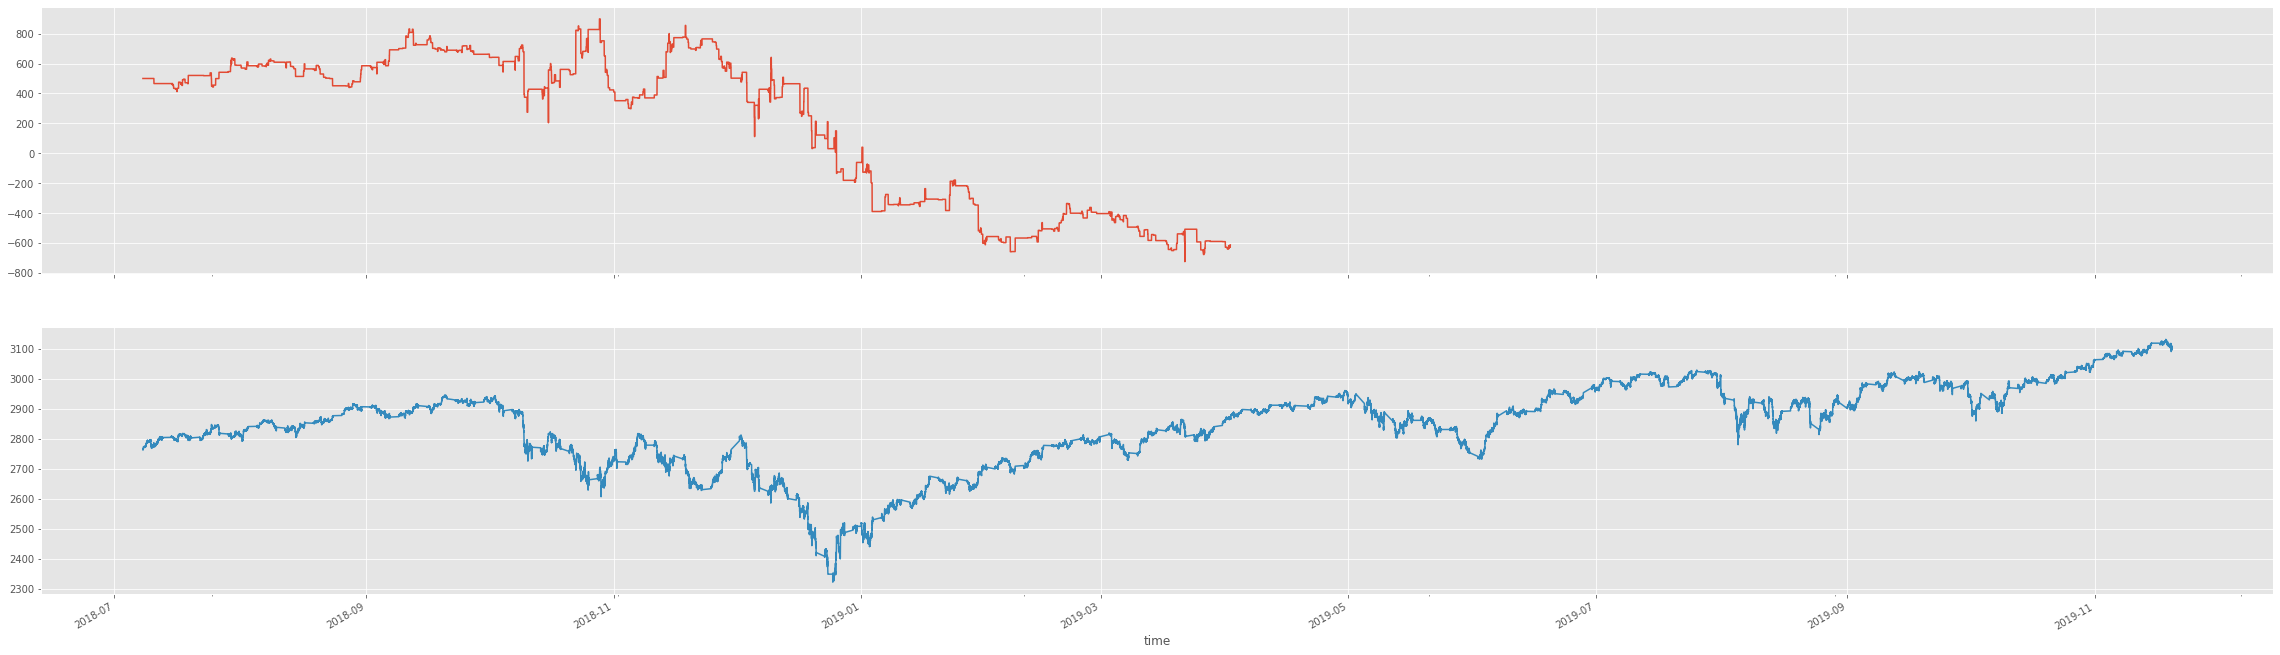

In [17]:
pro[0]['Resultados acumulados'] = pro[0]['Resultados acumulados']*5
pro[0][['Resultados acumulados','Open']].plot(subplots = True, grid = True, legend = False, figsize=(40, 12))

pro